## Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade langgraph transformers peft accelerate bitsandbytes "scikit-learn==1.6.1" joblib "pandas==2.2.2" langchain-core langchain

## Notebook Setup

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import os
import sqlite3
import torch
from typing import TypedDict, Optional, Dict, Literal
from pydantic import BaseModel, field_validator
from math import exp
from datetime import datetime

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# DEFINE PATHS

BASE_PATH           = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized" # CHANGE THIS WHEN YOU USE THE NOTEBOOK, ENSURE THE FINAL DESTINATION IS Capstone_Organized
ML_ARTIFACT_PATH    = BASE_PATH + "/3-Model_Training/3.1-Traditional_ML/3.1.0-Traditional_ML_Artifacts"
LLM_ARTIFACT_PATH   = BASE_PATH + "/3-Model_Training/3.2-LLM_Classification/3.2.0-FineTune_OpenBioLLM"

DB_PATH             = os.path.join(BASE_PATH + "/1-Data/ED_Simulated_Database_Fixed.db")

ML_MODEL_PATH       = os.path.join(ML_ARTIFACT_PATH, "gb_model.joblib")
ML_PREPROCESSOR_PATH= os.path.join(ML_ARTIFACT_PATH, "ml_preprocessor.joblib")
ML_FEATURES_PATH    = os.path.join(ML_ARTIFACT_PATH, "ml_feature_columns.json")

LLM_MODEL_ID        = "aaditya/Llama3-OpenBioLLM-8B"
LLM_MODEL_PATH      = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Final")
LLM_OFFLOAD_PATH    = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Offload")
os.makedirs(LLM_OFFLOAD_PATH, exist_ok=True)

assert os.path.exists(ML_MODEL_PATH), f"ML Model not found: {ML_MODEL_PATH}"
assert os.path.exists(ML_PREPROCESSOR_PATH), f"ML Preprocessor not found: {ML_PREPROCESSOR_PATH}"
assert os.path.exists(ML_FEATURES_PATH), f"ML Features JSON not found: {ML_FEATURES_PATH}"
assert os.path.exists(LLM_MODEL_PATH), f"LLM Checkpoint not found: {LLM_MODEL_PATH}"
assert os.path.exists(DB_PATH), f"Simulation DB not found: {DB_PATH}"

print("All model artifacts and simulation DB paths are verified.")

All model artifacts and simulation DB paths are verified.


## Log Setup

In [ ]:
import json
import os
import uuid
import time
import traceback
from datetime import datetime
from typing import Optional, Dict, Any
from contextlib import contextmanager

LOG_PATH = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/4-LangGraph/4.0-LangGraph_Logs/trace_log.jsonl" # adjust path
ERROR_LOG_PATH = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/4-LangGraph/4.0-LangGraph_Logs/error_log.jsonl" # adjust path

# Global execution context for traceability
_execution_context = {
    "execution_id": None,
    "visit_id": None,
    "start_time": None,
}

def init_execution_context(visit_id: int):
    """Initialize execution context for a new workflow run."""
    _execution_context["execution_id"] = str(uuid.uuid4())
    _execution_context["visit_id"] = visit_id
    _execution_context["start_time"] = time.time()
    return _execution_context["execution_id"]

def get_execution_id() -> Optional[str]:
    """Get current execution ID for traceability."""
    return _execution_context.get("execution_id")

def _make_json_safe(obj):
    """
    Recursively convert objects into JSON-serializable forms.

    Rules:
    - dict     → clean keys and values
    - list/tuple → clean each element
    - basic types (int, float, str, bool, None) → keep as-is
    - anything else (custom classes like VitalSigns) → convert to str(obj)
    """
    # Basic scalar types that JSON can handle directly
    if isinstance(obj, (int, float, str, bool)) or obj is None:
        return obj

    # dict: clean each key/value
    if isinstance(obj, dict):
        return {str(k): _make_json_safe(v) for k, v in obj.items()}

    # list or tuple: clean each element
    if isinstance(obj, (list, tuple)):
        return [_make_json_safe(v) for v in obj]

    # Fallback: custom object, dataclass, pydantic model, etc.
    # We serialize it via its string representation.
    return str(obj)


def log_event(step: str, input_state: dict, output_state: dict, meta: dict = None,
              execution_id: Optional[str] = None, duration_ms: Optional[float] = None,
              error: Optional[str] = None):
    """
    Enhanced logging utility with execution tracking and performance metrics.

    Args:
        step: Name of the step/node
        input_state: Input state dictionary
        output_state: Output state dictionary
        meta: Additional metadata
        execution_id: Unique execution ID for traceability
        duration_ms: Execution duration in milliseconds
        error: Error message if any
    """
    execution_id = execution_id or get_execution_id()

    record = {
        "timestamp": datetime.now().isoformat(),
        "execution_id": execution_id,
        "step": step,
        "input_state": _make_json_safe(input_state),
        "output_state": _make_json_safe(output_state),
        "meta": _make_json_safe(meta or {}),
    }

    # Add performance metrics
    if duration_ms is not None:
        record["duration_ms"] = duration_ms
        record["meta"]["performance"] = {"duration_ms": duration_ms}

    # Add error information if present
    if error:
        record["error"] = error
        record["meta"]["error"] = error

    # Append one line per event
    try:
        with open(LOG_PATH, "a") as f:
            f.write(json.dumps(record) + "\n")
    except Exception as e:
        print(f"[WARNING] Failed to write to log file: {e}")

    # Optional console debug
    log_msg = f"[LOG] execution_id={execution_id} step={step}"
    if duration_ms is not None:
        log_msg += f" duration={duration_ms:.2f}ms"
    if error:
        log_msg += f" ERROR={error[:100]}"
    print(log_msg)


def log_error(step: str, error: Exception, state: dict = None, execution_id: Optional[str] = None):
    """
    Log errors with full context for debugging.

    Args:
        step: Name of the step where error occurred
        error: Exception object
        state: State at time of error
        execution_id: Unique execution ID
    """
    execution_id = execution_id or get_execution_id()

    error_record = {
        "timestamp": datetime.now().isoformat(),
        "execution_id": execution_id,
        "step": step,
        "error_type": type(error).__name__,
        "error_message": str(error),
        "traceback": traceback.format_exc(),
        "state": _make_json_safe(state or {}),
    }

    try:
        with open(ERROR_LOG_PATH, "a") as f:
            f.write(json.dumps(error_record) + "\n")
    except Exception as e:
        print(f"[WARNING] Failed to write to error log file: {e}")

    print(f"[ERROR] execution_id={execution_id} step={step} error={type(error).__name__}: {str(error)}")


@contextmanager
def track_performance(step_name: str):
    """Context manager to track execution time of a step."""
    start_time = time.time()
    try:
        yield
    finally:
        duration_ms = (time.time() - start_time) * 1000
        print(f"[PERF] {step_name} took {duration_ms:.2f}ms")

In [ ]:
import copy
from functools import wraps

def make_logged_node(fn, name: str, max_retries: int = 0, retry_delay: float = 0.1):
    """
    Enhanced node wrapper with:
    - Comprehensive logging with execution IDs
    - Performance tracking
    - Error handling with graceful degradation
    - Retry logic for transient failures
    - State validation

    Args:
        fn: Node function to wrap
        name: Name of the node for logging
        max_retries: Maximum number of retries for transient failures (0 = no retries)
        retry_delay: Delay between retries in seconds
    """
    def _to_serializable_dict(obj):
        """Recursively converts Pydantic BaseModel instances to dictionaries within a dict/list."""
        if isinstance(obj, BaseModel):
            return obj.model_dump()
        elif isinstance(obj, dict):
            return {k: _to_serializable_dict(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [_to_serializable_dict(elem) for elem in obj]
        return obj

    def _validate_state(state: dict, required_keys: list) -> tuple[bool, Optional[str]]:
        """Validate that required keys exist in state."""
        missing = [key for key in required_keys if key not in state or state[key] is None]
        if missing:
            return False, f"Missing required state keys: {missing}"
        return True, None

    @wraps(fn)
    def wrapped(state):
        execution_id = get_execution_id()
        start_time = time.time()

        # Create a deep copy of the state and convert Pydantic objects for logging input
        serializable_input_state = _to_serializable_dict(copy.deepcopy(state))

        # Log input
        log_event(
            f"{name}_INPUT",
            serializable_input_state,
            {},
            execution_id=execution_id
        )

        # Retry logic for transient failures
        last_error = None
        for attempt in range(max_retries + 1):
            try:
                # Run original node
                with track_performance(f"{name}_node"):
                    out = fn(state)

                # Validate output
                if out is None:
                    out = {}  # Ensure we always return a dict

                # Calculate duration
                duration_ms = (time.time() - start_time) * 1000

                # Create a deep copy of the output and convert Pydantic objects for logging output
                serializable_current_state_for_output_log = _to_serializable_dict(copy.deepcopy(state))
                serializable_output_from_node = _to_serializable_dict(copy.deepcopy(out))

                # Log output with performance metrics
                log_event(
                    f"{name}_OUTPUT",
                    serializable_current_state_for_output_log,
                    serializable_output_from_node,
                    execution_id=execution_id,
                    duration_ms=duration_ms
                )

                return out

            except Exception as e:
                last_error = e
                duration_ms = (time.time() - start_time) * 1000

                # Log error
                log_error(name, e, state, execution_id)

                # If this is the last attempt, handle the error
                if attempt == max_retries:
                    # Log failed attempt
                    log_event(
                        f"{name}_ERROR",
                        serializable_input_state,
                        {},
                        execution_id=execution_id,
                        duration_ms=duration_ms,
                        error=f"{type(e).__name__}: {str(e)}"
                    )

                    # For critical nodes, we might want to raise
                    # For non-critical nodes, return a safe default
                    if name in ["fetch_data", "severity_gate"]:
                        # Critical nodes - re-raise
                        raise
                    else:
                        # Non-critical nodes - return safe defaults
                        print(f"[WARNING] {name} failed after {max_retries + 1} attempts, using safe defaults")
                        return _get_safe_default_output(name, state)
                else:
                    # Wait before retry
                    time.sleep(retry_delay * (attempt + 1))  # Exponential backoff
                    print(f"[RETRY] {name} attempt {attempt + 1}/{max_retries + 1}")

        # Should never reach here, but just in case
        return _get_safe_default_output(name, state)

    return wrapped


def _get_safe_default_output(node_name: str, state: dict) -> dict:
    """
    Return safe default outputs for nodes that fail.
    This allows the workflow to continue with degraded functionality.
    """
    defaults = {
        "ml_model": {"ml_score": 0.5},  # Neutral probability
        "llm_model": {"llm_score": 0.5},  # Neutral probability
        "human_input": {},  # No output needed
        "fusion": {
            "fused_prob": 0.5,
            "p_final": 0.5,
            "fusion_decision": "Error",
            "fusion_rationale": "Fusion failed, using default neutral probability."
        },
        "confidence_check": state,  # Pass through
        "human_review": {
            "fused_prob": state.get("fused_prob", state.get("p_final", 0.5)),
            "p_final": state.get("fused_prob", state.get("p_final", 0.5))
        },
        "finalize": {
            "decision": "UNKNOWN",
            "rationale": f"Workflow encountered errors. Node {node_name} failed.",
            "p_final": state.get("fused_prob", state.get("p_final", 0.5))
        }
    }
    return defaults.get(node_name, {})

## Load Artifacts & Define Helper Functions

In [ ]:
# LOAD ML ARTIFACTS

# Define function for joblib pointer
def clean_text_for_ml(text: str) -> str:
    """
    Cleans the triage notes for TF-IDF.
    This version removes the [AGE] tags and all non-alpha characters.
    (Copied from 3.1.1-Traditional_ML_Training.ipynb)
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\\[.*?\\]', ' ', text)    # Remove tags like [AGE]
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove special characters
    text = text.lower()                       # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Consolidate whitespace
    return text

# Load joblib files
ml_model = joblib.load(ML_MODEL_PATH)
ml_preprocessor = joblib.load(ML_PREPROCESSOR_PATH)

with open(ML_FEATURES_PATH, 'r') as f:
    ml_feature_names = json.load(f)

print(f"\nSuccessfully loaded ML model and preprocessor ({len(ml_feature_names)} features).")


Successfully loaded ML model and preprocessor (142 features).


/usr/lib/python3.12/pickle.py:1760: UserWarning: [17:46:45] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [ ]:
from peft import AutoPeftModelForSequenceClassification

classifier_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
if classifier_tokenizer.pad_token is None:
    classifier_tokenizer.pad_token = classifier_tokenizer.eos_token

# Use AutoPeftModelForSequenceClassification to load the fine-tuned model
llm_classifier_model = AutoPeftModelForSequenceClassification.from_pretrained(
    LLM_MODEL_PATH,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # Requires a GPU!
    offload_folder=LLM_OFFLOAD_PATH
)
llm_classifier_model.eval()

print("\nSuccessfully loaded fine-tuned OpenBioLLM model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Successfully loaded fine-tuned OpenBioLLM model.


In [ ]:
# LOAD LLM FUSION AGENT

# 1. Configure 4-bit quantization to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# 2. Load the base model with AutoModelForCausalLM
llm_fusion_model = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL_ID,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
)

# 3. Load its tokenizer
fusion_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID, trust_remote_code=True)
if fusion_tokenizer.pad_token is None:
    fusion_tokenizer.pad_token = fusion_tokenizer.eos_token

print("\nSuccessfully loaded base OpenBioLLM *Fusion Agent* model.")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Successfully loaded base OpenBioLLM *Fusion Agent* model.


In [ ]:
# LOAD HELPER FUNCTIONS

# --- Helper for LLM Prediction ---
def format_for_llm_classifier(patient_data: dict) -> str:
    """Formats the raw DB row for the CLASSIFICATION model."""
    return (
        f"age range: {patient_data.get('age_bucket')} / "
        f"sex: {patient_data.get('sex')} / "
        f"heart rate: {patient_data.get('heart_rate')} / "
        f"systolic blood pressure: {patient_data.get('bp_systolic')} / "
        f"diastolic blood pressure: {patient_data.get('bp_diastolic')} / "
        f"respiratory rate: {patient_data.get('resp_rate')} / "
        f"temperature in Celsius: {patient_data.get('temperature_C')} / "
        f"oxygen saturation: {patient_data.get('oxygen_saturation')} / "
        f"ESI: {int(patient_data.get('ESI', 0))} / "
        f"recent admissions (in 30 days): {int(patient_data.get('recent_admissions_30d', 0))} / "
        f"{patient_data.get('triage_notes_redacted', '')}"
    )

def llm_predict_proba(text: str) -> float:
    """Runs the formatted text through the CLASSIFIER and returns P(Admit)."""
    device = llm_classifier_model.device
    inputs = classifier_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = llm_classifier_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
        return float(probs[1].cpu().numpy())


# --- Helper for ML Prediction ---
def ml_predict_proba(patient_data: dict) -> float:
    """Runs the raw data through the ML preprocessor and model."""
    input_df = pd.DataFrame([patient_data])
    transformed_data = ml_preprocessor.transform(input_df)
    input_transformed_df = pd.DataFrame(transformed_data.toarray(), columns=ml_feature_names)
    prob_admit = ml_model.predict_proba(input_transformed_df)[0][1]
    return float(prob_admit)

print("Model helper functions defined.")

Model helper functions defined.


In [ ]:
def run_fusion_agent(ml_prob: float, llm_prob: float, human_note: str) -> dict:
    """
    Uses the generative LLM to synthesize inputs and make a
    final decision with rationale.
    """

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert ER triage physician. Your job is to synthesize three signals to make a final, clinically sound admission decision.

You are given three inputs:
1) p_ml:  probability of admission from a traditional ML model.
2) p_llm: probability of admission from an LLM classifier.
3) human_note: short free-text note from a nurse or physician providing real-time context.

Your task:
- Interpret all three signals.
- Resolve disagreements between the signals.
- Produce ONE final admission decision.
- Provide ONE rationale explaining exactly WHY you chose "Admit" or "Discharge".
  * Your rationale MUST explicitly reference p_ml, p_llm, and human_note.
  * It MUST give a clear clinical justification (e.g., high risk → admit, stable symptoms → discharge).

Output STRICTLY as a single valid JSON object with EXACTLY two keys:
{{
  "decision": "Admit" | "Discharge",
  "rationale": "string (2–4 sentences explaining the reason for your decision based on p_ml, p_llm, and human_note)"
}}

Do NOT output anything else.
Do NOT add comments or markdown.
Return ONLY the JSON object.
<|eot_id|><|start_header_id|>user<|end_header_id|>
Please make a final decision based on this information:
- p_ml (ML model): {ml_prob:.2f}
- p_llm (LLM classifier): {llm_prob:.2f}
- human_note: "{human_note}"

Return ONLY the JSON object described above:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

    device = llm_fusion_model.device
    inputs = fusion_tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the response
    with torch.no_grad():
        outputs = llm_fusion_model.generate(
            **inputs,
            max_new_tokens=150,
            eos_token_id=fusion_tokenizer.eos_token_id
        )

    # Decode and clean the output
    response_text = fusion_tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Extract the JSON part
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group(0))
        except json.JSONDecodeError:
            return {"decision": "Error", "rationale": "Failed to parse LLM JSON response."}
    else:
        return {"decision": "Error", "rationale": "No JSON object found in LLM response."}

print("Fusion helper functions defined.")

Fusion helper functions defined.


## Define Graph State

In [ ]:
class VitalSigns(BaseModel):
    """Pydantic model for validating vital signs."""
    sex: Optional[str] = None
    age_bucket: Optional[str] = None
    heart_rate: Optional[float] = None
    resp_rate: Optional[float] = None
    bp_systolic: Optional[float] = None
    bp_diastolic: Optional[float] = None
    oxygen_saturation: Optional[float] = None
    temperature_C: Optional[float] = None
    ESI: Optional[int] = None
    mental_status: Optional[str] = None
    recent_admissions_30d: Optional[int] = None


class ERState(TypedDict, total=False):
    """Defines the state of our graph with optional fields for robustness."""
    visit_id: int
    human_prompt: str
    patient_data: Dict
    vitals_validated: VitalSigns
    triage_text: str
    ml_score: Optional[float]
    llm_score: Optional[float]
    severe: Optional[bool]
    p_final: Optional[float]
    fused_prob: Optional[float]
    decision: Optional[str]
    final_decision: Optional[str]
    confidence: Optional[float]
    rationale: Optional[str]
    fusion_decision: Optional[str]
    fusion_rationale: Optional[str]
    human_override: Optional[float]
    execution_id: Optional[str]  # For traceability
    error_log: Optional[list]  # Track errors during execution

print("LangGraph state defined with enhanced optional fields for robustness.")


def validate_initial_state(state: dict) -> tuple[bool, Optional[str]]:
    """
    Validate initial state before workflow execution.

    Returns:
        (is_valid, error_message)
    """
    required = ["visit_id"]
    missing = [key for key in required if key not in state]
    if missing:
        return False, f"Missing required initial state keys: {missing}"

    if not isinstance(state.get("visit_id"), int) or state["visit_id"] <= 0:
        return False, f"Invalid visit_id: {state.get('visit_id')}"

    return True, None


def validate_state_transition(state: dict, node_name: str) -> tuple[bool, Optional[str]]:
    """
    Validate state before node execution based on node requirements.

    Returns:
        (is_valid, error_message)
    """
    node_requirements = {
        "fetch_data": ["visit_id"],
        "severity_gate": ["vitals_validated"],
        "ml_model": ["patient_data"],
        "llm_model": ["patient_data"],
        "human_input": ["human_prompt"],
        "fusion": ["ml_score", "llm_score"],
        "confidence_check": ["ml_score", "llm_score", "fused_prob"],
        "human_review": ["fused_prob"],
        "finalize": ["fused_prob"],
    }

    required = node_requirements.get(node_name, [])
    missing = [key for key in required if key not in state or state[key] is None]
    if missing:
        return False, f"Node {node_name} missing required state keys: {missing}"

    return True, None

LangGraph state defined with enhanced optional fields for robustness.


In [ ]:
# --- Node 1: Fetch Data from DB ---
def fetch_data_node(state: ERState):
    """
    Fetch Data Node
    ---------------
    Takes a visit_id, connects to the DB, and fetches the patient's
    de-identified data from Visit_Details, Triage_Notes, and ESI.

    According to the diagram flow:
    - START → fetch_data (solid arrow)
    - fetch_data → severity_gate (solid arrow)

    Enhanced with:
    - Input validation
    - Better error messages
    - Execution ID tracking
    """
    visit_id = state.get('visit_id')
    execution_id = get_execution_id()

    # Validate input
    if not visit_id or not isinstance(visit_id, int) or visit_id <= 0:
        raise ValueError(f"Invalid visit_id: {visit_id}")

    print(f"--- 1. Fetching data for visit_id: {visit_id} (execution_id: {execution_id}) ---")

    # Initialize execution context if not already set
    if execution_id is None:
        init_execution_context(visit_id)
        execution_id = get_execution_id()

    # Update state with execution ID for traceability
    state_update = {"execution_id": execution_id}

    conn = None
    try:
        # Validate DB path exists
        if not os.path.exists(DB_PATH):
            raise FileNotFoundError(f"Database file not found: {DB_PATH}")

        conn = sqlite3.connect(DB_PATH, timeout=10.0)  # Add timeout
        conn.row_factory = sqlite3.Row

        query = """
        SELECT
            v.visit_id, v.patient_id, v.sex, v.age_bucket,
            v.heart_rate, v.bp_systolic, v.bp_diastolic, v.resp_rate,
            v.temperature_C, v.oxygen_saturation, v.recent_admissions_30d,
            v.admitted,
            t.triage_notes_redacted,
            e.ESI
        FROM Visit_Details v
        LEFT JOIN Triage_Notes t ON v.visit_id = t.visit_id AND v.patient_id = t.patient_id
        LEFT JOIN ESI e ON v.visit_id = e.visit_id AND v.patient_id = e.patient_id
        WHERE v.visit_id = ?
        """

        cursor = conn.cursor()
        cursor.execute(query, (visit_id,))
        row = cursor.fetchone()

    except sqlite3.Error as e:
        error_msg = f"Database error for visit_id {visit_id}: {str(e)}"
        log_error("fetch_data", e, state, execution_id)
        raise RuntimeError(error_msg) from e
    except Exception as e:
        error_msg = f"Unexpected error fetching data for visit_id {visit_id}: {str(e)}"
        log_error("fetch_data", e, state, execution_id)
        raise
    finally:
        if conn:
            try:
                conn.close()
            except Exception:
                pass  # Ignore errors during cleanup

    if row is None:
        error_msg = f"No data found for visit_id: {visit_id} in {DB_PATH}"
        raise ValueError(error_msg)

    patient_data = dict(row)

    # Validate that we have essential data
    if not patient_data.get('visit_id'):
        raise ValueError(f"Invalid patient data returned for visit_id: {visit_id}")

    # Validate vitals with error handling
    try:
        vitals_validated = VitalSigns(**patient_data)
    except Exception as e:
        log_error("fetch_data_vitals_validation", e, {"patient_data": patient_data}, execution_id)
        # Try to create with minimal required fields
        vitals_validated = VitalSigns(
            sex=patient_data.get('sex'),
            age_bucket=patient_data.get('age_bucket'),
            heart_rate=patient_data.get('heart_rate'),
            resp_rate=patient_data.get('resp_rate'),
            bp_systolic=patient_data.get('bp_systolic'),
            bp_diastolic=patient_data.get('bp_diastolic'),
            oxygen_saturation=patient_data.get('oxygen_saturation'),
            temperature_C=patient_data.get('temperature_C'),
            ESI=patient_data.get('ESI'),
            recent_admissions_30d=patient_data.get('recent_admissions_30d')
        )

    state_update.update({
        "patient_data": patient_data,
        "vitals_validated": vitals_validated,
        "triage_text": patient_data.get('triage_notes_redacted', '')
    })

    return state_update

# --- Node 2: Severity Gate ---
def severity_gate_node(state: ERState):
    """
    Severity Gate Node
    ------------------
    Checks for any critical vital signs that would require immediate admission.

    According to the diagram flow:
    - fetch_data → severity_gate (solid arrow)
    - severity_gate has two conditional paths:
      1. Early exit (dotted arrow labeled "end") → END
      2. Continue (dotted arrow) → run_models
    """
    print("--- 2. Checking severity gate ---")
    v = state["vitals_validated"]

    if (v.oxygen_saturation is not None and v.oxygen_saturation < 88) or \
       (v.bp_systolic is not None and v.bp_systolic < 80) or \
       (v.resp_rate is not None and (v.resp_rate > 35 or v.resp_rate < 8)):
        print(" -> CRITICAL: Patient is severe. Bypassing models.")
        return {
            "severe": True,
            "decision": "Admit",
            "p_final": 1.0,
            "rationale": "Critical vital signs detected. Bypassed ML/LLM."
        }

    print(" -> OK: Patient is not severe. Proceeding to models.")
    return {"severe": False}

In [ ]:
# --- Node 3a: ML Model ---
def ml_model_node(state: ERState):
    """
    ML Model Node
    -------------
    Runs the patient data through the retrained ML pipeline.

    According to the diagram flow:
    - run_models → ml_model (solid arrow, parallel execution)
    - ml_model → fusion (solid arrow, converges with other models)

    Enhanced with:
    - Input validation
    - Error handling with fallback
    - Score validation (0-1 range)
    """
    print("--- 3a. Running ML Model ---")

    # Validate input
    patient_data = state.get('patient_data')
    if not patient_data:
        raise ValueError("Missing patient_data for ML model")

    try:
        score = ml_predict_proba(patient_data)

        # Validate score is in valid range
        if not isinstance(score, (int, float)) or score < 0 or score > 1:
            print(f"[WARNING] ML model returned invalid score: {score}, clamping to [0, 1]")
            score = max(0.0, min(1.0, float(score)))

        print(f" -> ML Score (P_Admit): {score:.4f}")
        return {"ml_score": float(score)}

    except Exception as e:
        log_error("ml_model", e, state, get_execution_id())
        # Return neutral score on error
        print(f"[WARNING] ML model failed, using neutral score: {e}")
        return {"ml_score": 0.5}

# --- Node 3b: LLM Model ---
def llm_model_node(state: ERState):
    """
    LLM Model Node
    --------------
    Runs the patient data through the retrained LLM pipeline.

    According to the diagram flow:
    - run_models → llm_model (solid arrow, parallel execution)
    - llm_model → fusion (solid arrow, converges with other models)

    Enhanced with:
    - Input validation
    - Error handling with fallback
    - Score validation (0-1 range)
    """
    print("--- 3b. Running LLM Classifier ---")

    # Validate input
    patient_data = state.get('patient_data')
    if not patient_data:
        raise ValueError("Missing patient_data for LLM model")

    try:
        formatted_text = format_for_llm_classifier(patient_data)

        # Validate formatted text is not empty
        if not formatted_text or not formatted_text.strip():
            print("[WARNING] Empty formatted text for LLM, using default")
            formatted_text = "No patient data available."

        score = llm_predict_proba(formatted_text)

        # Validate score is in valid range
        if not isinstance(score, (int, float)) or score < 0 or score > 1:
            print(f"[WARNING] LLM model returned invalid score: {score}, clamping to [0, 1]")
            score = max(0.0, min(1.0, float(score)))

        print(f" -> LLM Classifier Score (P_Admit): {score:.4f}")
        return {"llm_score": float(score)}

    except Exception as e:
        log_error("llm_model", e, state, get_execution_id())
        # Return neutral score on error
        print(f"[WARNING] LLM model failed, using neutral score: {e}")
        return {"llm_score": 0.5}

# --- Node 3c: Human Input ---
def human_input_node(state: ERState):
    """
    Human Input Node
    ---------------
    This node acknowledges and processes the human prompt/note.

    According to the diagram flow:
    - run_models → human_input (solid arrow, parallel execution)
    - human_input → fusion (solid arrow, converges with other models)
    """
    print("--- 3c. Acknowledging Human Input ---")
    print(f" -> Human Note: '{state['human_prompt']}'")
    return {}

In [ ]:
# --- Node 4: Fusion ---
def fusion_node(state: ERState):
    """
    Fusion Node
    -----------
    Fuses the outputs from human_input, llm_model, and ml_model.

    According to the diagram flow:
    - human_input, llm_model, ml_model → fusion (solid arrows, all converge)
    - fusion → confidence_check (solid arrow)

    Calls the generative fusion agent (run_fusion_agent) to produce:
      - fusion_decision    : "Admit" / "Discharge" / "Error"
      - fusion_rationale   : textual explanation (2–4 sentences)

    Also computes a numeric fused probability:
      fused_prob = 0.5 * ml_prob + 0.5 * llm_prob

    Returns a partial state update with:
      - fused_prob
      - p_final            (alias for fused_prob)
      - fusion_decision
      - fusion_rationale
    """

    print("--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---")

    # Validate and extract inputs with defaults
    ml_prob = state.get("ml_score")
    llm_prob = state.get("llm_score")
    human_note = (state.get("human_prompt") or "").strip()

    # Validate scores exist and are valid
    if ml_prob is None:
        print("[WARNING] ml_score missing, using default 0.5")
        ml_prob = 0.5
    if llm_prob is None:
        print("[WARNING] llm_score missing, using default 0.5")
        llm_prob = 0.5

    # Ensure scores are in valid range
    ml_prob = max(0.0, min(1.0, float(ml_prob)))
    llm_prob = max(0.0, min(1.0, float(llm_prob)))

    execution_id = get_execution_id()

    # 1) Call fusion agent with error handling
    fusion_output = None
    fusion_error = None
    try:
        fusion_output = run_fusion_agent(
            ml_prob=ml_prob,
            llm_prob=llm_prob,
            human_note=human_note,
        )

        # Validate fusion output
        if not isinstance(fusion_output, dict):
            raise ValueError("Fusion agent returned non-dict output")

    except Exception as e:
        fusion_error = str(e)
        log_error("fusion_agent", e, state, execution_id)
        print(f" -> Fusion agent raised an exception: {e}")
        fusion_output = {
            "decision": "Error",
            "rationale": f"Exception during fusion agent call: {e}. Using weighted average.",
        }

    fusion_decision = fusion_output.get("decision", "Error") if fusion_output else "Error"
    fusion_rationale = fusion_output.get(
        "rationale",
        "No rationale returned by fusion agent. Using weighted average of ML and LLM scores."
    ) if fusion_output else "Fusion agent failed. Using weighted average."

    # 2) Numeric fused probability (always compute as fallback)
    fused_prob = 0.5 * ml_prob + 0.5 * llm_prob

    # If fusion agent failed, use weighted average as decision
    if fusion_error or fusion_decision == "Error":
        if fused_prob >= 0.5:
            fusion_decision = "Admit"
        else:
            fusion_decision = "Discharge"
        fusion_rationale = f"Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = {fused_prob:.3f}. Decision: {fusion_decision}."

    print(
        f" -> Final P(Admit) Score (numeric): {fused_prob:.4f} | "
        f"Fusion Agent Decision: {fusion_decision}"
    )
    print(f" -> Fusion Agent Rationale (inside fusion_node): {fusion_rationale}")

    # 3) VERY IMPORTANT: return all fields you want to keep in the state
    return {
        "fused_prob": float(fused_prob),
        "p_final": float(fused_prob),
        "fusion_decision": fusion_decision,
        "fusion_rationale": fusion_rationale,
    }



# --- Conditional Edge: Severity Gate ---
def conditional_severity_gate(state: ERState):
    """
    Conditional Severity Gate Routing
    ----------------------------------
    Routes the workflow based on severity assessment:
    - If severe (critical vitals) → "end" (early exit to END)
    - If not severe → "run_models" (proceed to parallel model execution)

    This matches the diagram flow where severity_gate has two paths:
    1. Early exit path (dotted arrow labeled "end") → END
    2. Continue path (dotted arrow) → run_models
    """
    if state.get("severe", False):
        print("[Routing] Severe case detected → early exit to END")
        return "end"  # Go straight to the end (early exit path)
    else:
        print("[Routing] Non-severe case → proceeding to run_models")
        return "run_models"  # Proceed to parallel branches

print("Fusion & Logic nodes defined.")

Fusion & Logic nodes defined.


In [ ]:
ADMISSION_THRESHOLD = 0.5 #Use default threshold 0.5 (this will be tuned when we find the optimal threshold)

def confidence_check_node(state: ERState):
    """
    Confidence Check Node
    ---------------------
    This node is executed after the fusion step.

    According to the diagram flow:
    - fusion → confidence_check (solid arrow)
    - confidence_check has two conditional paths:
      1. high_confidence (dotted arrow) → finalize
      2. low_confidence (dotted arrow) → human_review

    Purpose:
    - Validate that ML and LLM scores exist in the state.
    - Print debugging information for verification.
    - Pass-through node (no state modification).

    NOTE:
    The actual routing decision (high vs. low confidence)
    is performed by `conditional_confidence_routing`.
    """
    ml = state.get("ml_score")
    llm = state.get("llm_score")
    fused_prob = state.get("fused_prob", state.get("p_final"))
    print("--- 5. Confidence Check Node ---")
    print(f"[ConfidenceCheck] ml_score={ml:.4f}, llm_score={llm:.4f}, fused_prob={fused_prob:.4f}")
    return state

def human_review_node(state: ERState):
    """
    Human Review Node (HITL - Human In The Loop)
    ---------------------------------------------
    This node is executed when confidence_check routes to low_confidence.

    According to the diagram flow:
    - confidence_check → low_confidence (dotted arrow) → human_review
    - human_review → finalize (solid arrow)

    This node provides human oversight for low-confidence cases.

    Workflow:
    1. On first pass, LangGraph stops *before* this node
       if interrupt_before=["human_review"] is set.
    2. You manually inspect the state via get_state().
    3. You insert state["human_override"] manually.
    4. The graph is resumed → this node executes.

    Behavior:
    - If human_override exists → override fused_prob.
    - If not → use the original fused_prob.

    This ensures fully traceable HITL correction.
    """
    print("--- 6. Human Review Node (HITL) ---")
    override = state.get("human_override", None)

    if override is not None:
        output = {"fused_prob": float(override), "p_final": float(override)}
        log_event("human_review_override", dict(state), output)
        print(f"[HITL] Human override applied → fused_prob={override:.4f}")
        return output

    # No override → retain original fused_prob
    fused_prob = state.get("fused_prob", state.get("p_final"))
    output = {"fused_prob": float(fused_prob), "p_final": float(fused_prob)}
    log_event("human_review_no_override", dict(state), output)
    print(f"[HITL] No override provided → using original fused_prob={fused_prob:.4f}")
    return output



# 2d. finalize node
def finalize_node(state: ERState):
    """
    Finalize Node
    -------------
    This node produces the final admission decision and rationale.

    According to the diagram flow:
    - finalize can be reached from two paths:
      1. confidence_check → high_confidence (dotted arrow) → finalize
      2. confidence_check → low_confidence → human_review → finalize (solid arrow)
    - finalize → END (solid arrow)

    Decision rule:
      - ADMIT     if fused_prob >= ADMISSION_THRESHOLD
      - DISCHARGE if fused_prob <  ADMISSION_THRESHOLD
      - UNKNOWN   if fused_prob is missing

    It writes the following fields into the state:
      - final_decision : canonical final decision
      - rationale      : canonical final rationale
      - decision       : backward-compatible alias
      - p_final        : backward-compatible alias for fused_prob

    IMPORTANT:
      - We start from the existing state (`dict(state)`) so that
        previous fields like `fusion_rationale` are preserved.
    """

    print("--- 7. Finalize Node ---")

    # Prefer fused_prob, but fall back to p_final if needed
    fused = state.get("fused_prob", state.get("p_final", None))

    if fused is None:
        decision = "UNKNOWN"
        rationale = (
            "Missing fused_prob; unable to generate a final decision. "
            "Check fusion or human review steps."
        )
    else:
        # Use global threshold
        print(f"[Finalize] Using Admission Threshold: {ADMISSION_THRESHOLD:.4f}")

        if fused >= ADMISSION_THRESHOLD:
            decision = "ADMIT"
            rationale = (
                f"Fused probability {fused:.2f} ≥ threshold {ADMISSION_THRESHOLD:.2f}; "
                "patient should be admitted."
            )
        else:
            decision = "DISCHARGE"
            rationale = (
                f"Fused probability {fused:.2f} < threshold {ADMISSION_THRESHOLD:.2f}; "
                "patient may be safely discharged."
            )

    # Merge decision fields back into the *existing* state
    new_state = dict(state)
    new_state["final_decision"] = decision
    new_state["rationale"] = rationale

    # Backward-compatible aliases
    new_state["decision"] = decision
    new_state["p_final"] = fused

    log_event("finalize_node", dict(state), new_state)
    print(f"[Finalize] Decision={decision}, Rationale={rationale}")

    return new_state


# 2e. confidence routing function（decide high / low confidence）
def conditional_confidence_routing(state: ERState):
    """
    Conditional Confidence Routing
    ------------------------------
    This function determines whether the workflow should:
    - Auto-complete the decision (high confidence), OR
    - Trigger a Human Review (low confidence)

    According to the diagram flow:
    - confidence_check has two conditional paths:
      1. high_confidence (dotted arrow) → finalize
      2. low_confidence (dotted arrow) → human_review

    It returns one of ONLY these keys (must match add_conditional_edges):
        - "high_confidence"
        - "low_confidence"

    This ensures LangGraph can correctly route AND
    ensures the interrupt_before=["human_review"] will fire
    when low confidence is detected.

    Routing Logic:
    1. If ML or LLM score is missing → LOW CONFIDENCE (force review)
    2. Compute:
        - probability gap = |ml_score - llm_score|
        - average score   = (ml_score + llm_score) / 2
    3. High confidence if:
        - gap < 0.20  AND  avg > 0.70
    4. Otherwise → low confidence → human review
    """
    ml = state.get("ml_score")
    llm = state.get("llm_score")

    # Missing scores → force human review
    if ml is None or llm is None:
        print("[Routing] Missing ML/LLM scores → LOW confidence → human_review")
        return "low_confidence"

    prob_gap = abs(ml - llm)
    avg_prob = (ml + llm) / 2

    HIGH_CONF_GAP = 0.20
    HIGH_CONF_THRESH = 0.70

    # High confidence path (matches diagram: high_confidence → finalize)
    if prob_gap < HIGH_CONF_GAP and avg_prob > HIGH_CONF_THRESH:
        print(f"[Routing] HIGH confidence (gap={prob_gap:.2f}, avg={avg_prob:.2f}) → finalize")
        return "high_confidence"

    # Low confidence path (matches diagram: low_confidence → human_review)
    print(f"[Routing] LOW confidence (gap={prob_gap:.2f}, avg={avg_prob:.2f}) → human_review")
    return "low_confidence"


# Define a router node for parallel execution
def run_models_node(state: ERState):
    """
    Run Models Router Node
    ----------------------
    This is a router node that triggers the parallel model runs.

    According to the diagram flow:
    - severity_gate → run_models (dotted arrow, when not severe)
    - run_models fans out in parallel to:
      1. human_input (solid arrow)
      2. llm_model (solid arrow)
      3. ml_model (solid arrow)
    - All three converge into fusion (solid arrows from each)
    """
    print("--- 3. Fanning out to parallel models (human_input, llm_model, ml_model) ---")
    return {}

## Initiate the Graph

In [ ]:
# 1. Initialize the graph
workflow = StateGraph(ERState)

In [ ]:
# ============================================
# Graph Construction - Matching Diagram Flow
# ============================================
# Flow according to diagram:
# START → fetch_data → severity_gate → (end OR run_models)
#   → run_models → [human_input, llm_model, ml_model] (parallel)
#   → fusion → confidence_check → (high_confidence OR low_confidence)
#   → (high_confidence → finalize) OR (low_confidence → human_review → finalize)
#   → finalize → END

# Add all the nodes with enhanced error handling and retry logic
# Critical nodes (fetch_data, severity_gate) have no retries - failures should be explicit
# Non-critical nodes can retry transient failures

workflow.add_node("fetch_data", make_logged_node(fetch_data_node, "fetch_data", max_retries=0))
workflow.add_node("severity_gate", make_logged_node(severity_gate_node, "severity_gate", max_retries=0))
workflow.add_node("run_models", make_logged_node(run_models_node, "run_models", max_retries=0))   # router node
workflow.add_node("ml_model", make_logged_node(ml_model_node, "ml_model", max_retries=1, retry_delay=0.5))
workflow.add_node("llm_model", make_logged_node(llm_model_node, "llm_model", max_retries=1, retry_delay=0.5))
workflow.add_node("human_input", make_logged_node(human_input_node, "human_input", max_retries=0))
workflow.add_node("fusion", make_logged_node(fusion_node, "fusion", max_retries=1, retry_delay=1.0))
workflow.add_node("confidence_check", make_logged_node(confidence_check_node, "confidence_check", max_retries=0))
workflow.add_node("human_review", make_logged_node(human_review_node, "human_review", max_retries=0))
workflow.add_node("finalize", make_logged_node(finalize_node, "finalize", max_retries=0))

# ============================================
# Define the graph flow (matching diagram)
# ============================================

# START → fetch_data (entry point)
workflow.set_entry_point("fetch_data")

# fetch_data → severity_gate (solid arrow)
workflow.add_edge("fetch_data", "severity_gate")

# severity_gate → conditional routing (matches diagram: two dotted arrows)
#   - "end" (early exit) → END
#   - "run_models" (continue) → run_models
workflow.add_conditional_edges(
    "severity_gate",
    conditional_severity_gate,
    {
        "run_models": "run_models",  # Continue path (dotted arrow in diagram)
        "end": END,                   # Early exit path (dotted arrow labeled "end" in diagram)
    },
)

# run_models → parallel fan-out (matches diagram: three solid arrows)
# All three models run in parallel
workflow.add_edge("run_models", "ml_model")
workflow.add_edge("run_models", "llm_model")
workflow.add_edge("run_models", "human_input")

# Converge into fusion (matches diagram: three solid arrows converging)
# All three parallel branches must complete before fusion runs
workflow.add_edge("ml_model", "fusion")
workflow.add_edge("llm_model", "fusion")
workflow.add_edge("human_input", "fusion")

# fusion → confidence_check (solid arrow)
workflow.add_edge("fusion", "confidence_check")

# confidence_check → conditional routing (matches diagram: two dotted arrows)
#   - "high_confidence" (dotted arrow) → finalize
#   - "low_confidence" (dotted arrow) → human_review
workflow.add_conditional_edges(
    "confidence_check",
    conditional_confidence_routing,
    {
        "high_confidence": "finalize",    # High confidence path (dotted arrow in diagram)
        "low_confidence": "human_review",  # Low confidence path (dotted arrow in diagram)
    },
)

# human_review → finalize (solid arrow)
# This path is taken when confidence is low
workflow.add_edge("human_review", "finalize")

# finalize → END (solid arrow)
workflow.add_edge("finalize", END)

# ============================================
# Compile the graph
# ============================================
memory = MemorySaver()
graph = workflow.compile(
    checkpointer=memory,
    #interrupt_before=["human_review"],  # Uncomment to enable HITL interrupt
)

print("\n--- LangGraph Compiled Successfully! ---")
print("Graph flow matches the diagram:")
print("  START → fetch_data → severity_gate → (end OR run_models)")
print("    → run_models → [human_input, llm_model, ml_model] (parallel)")
print("    → fusion → confidence_check → (high_confidence OR low_confidence)")
print("    → (high_confidence → finalize) OR (low_confidence → human_review → finalize)")
print("    → finalize → END")


--- LangGraph Compiled Successfully! ---
Graph flow matches the diagram:
  START → fetch_data → severity_gate → (end OR run_models)
    → run_models → [human_input, llm_model, ml_model] (parallel)
    → fusion → confidence_check → (high_confidence OR low_confidence)
    → (high_confidence → finalize) OR (low_confidence → human_review → finalize)
    → finalize → END


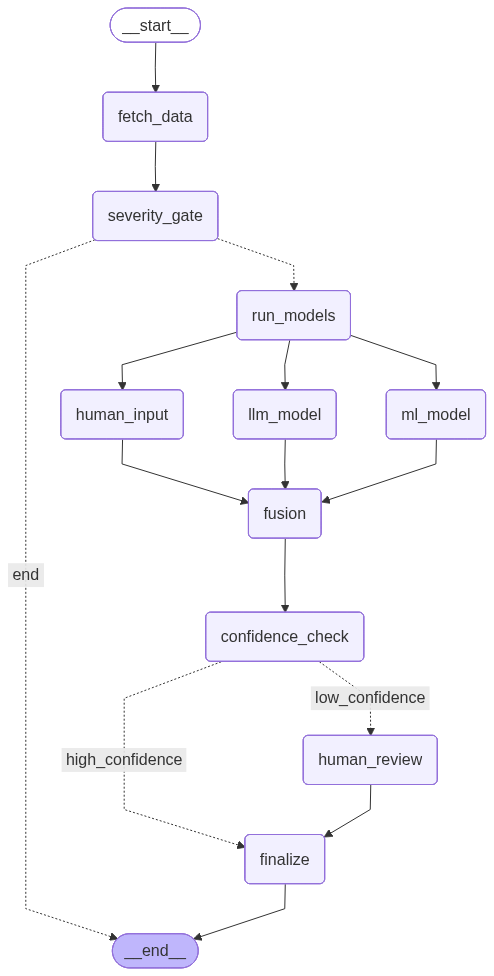

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Could not draw graph. Skipping visualization.")

## Test Run the Graph

In [ ]:
## Enhanced Workflow Invocation Helper

def invoke_workflow_with_tracking(graph, inputs: dict, config: dict = None):
    """
    Enhanced workflow invocation with automatic execution tracking.

    This function:
    1. Validates initial state
    2. Initializes execution context
    3. Invokes the graph
    4. Returns results with execution metadata

    Args:
        graph: Compiled LangGraph workflow
        inputs: Input state dictionary
        config: LangGraph configuration (optional)

    Returns:
        Final state dictionary with execution metadata
    """
    # Validate initial state
    is_valid, error_msg = validate_initial_state(inputs)
    if not is_valid:
        raise ValueError(f"Invalid initial state: {error_msg}")

    # Initialize execution context
    visit_id = inputs.get('visit_id')
    execution_id = init_execution_context(visit_id)

    print(f"\n{'='*60}")
    print(f"Starting workflow execution")
    print(f"  Execution ID: {execution_id}")
    print(f"  Visit ID: {visit_id}")
    print(f"{'='*60}\n")

    try:
        # Invoke graph
        if config is None:
            config = {"configurable": {"thread_id": f"exec-{execution_id}"}}

        final_state = graph.invoke(inputs, config)

        # Add execution metadata
        execution_time = time.time() - _execution_context["start_time"]
        final_state["execution_metadata"] = {
            "execution_id": execution_id,
            "visit_id": visit_id,
            "execution_time_seconds": execution_time,
            "timestamp": datetime.now().isoformat()
        }

        print(f"\n{'='*60}")
        print(f"Workflow execution completed")
        print(f"  Execution ID: {execution_id}")
        print(f"  Total time: {execution_time:.2f}s")
        print(f"  Final decision: {final_state.get('decision', 'N/A')}")
        print(f"{'='*60}\n")

        return final_state

    except Exception as e:
        execution_time = time.time() - _execution_context["start_time"]
        log_error("workflow_invocation", e, inputs, execution_id)

        print(f"\n{'='*60}")
        print(f"Workflow execution failed")
        print(f"  Execution ID: {execution_id}")
        print(f"  Time before failure: {execution_time:.2f}s")
        print(f"  Error: {type(e).__name__}: {str(e)}")
        print(f"{'='*60}\n")

        raise

print("Enhanced workflow invocation helper defined.")


Enhanced workflow invocation helper defined.


In [ ]:
# --- Run 1: High-Risk Patient Note ---
# We'll use visit_id=1 and add a high-risk note
inputs_1 = {
    "visit_id": 1,
    "human_prompt": "Patient is 70yo, frail, and on chemotherapy."
}
config = {"configurable": {"thread_id": "sim-1"}}

print("--- Running Simulation 1 (High-Risk Note) ---")
final_state_1 = graph.invoke(inputs_1, config)

print("\n--- Final State 1 ---")
print(f"Decision: {final_state_1.get('decision')}")
print(f"P(Admit): {final_state_1.get('p_final'):.4f}")
print(f"Final Rationale: {final_state_1.get('rationale')}")
print(f"Fusion Rationale: {final_state_1.get('fusion_rationale')}")


# --- Run 2: Low-Risk Patient Note ---
# We'll use visit_id=5 (assuming this is a lower-risk patient in the DB)
inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}
config = {"configurable": {"thread_id": "sim-2"}}

print("\n\n--- Running Simulation 2 (Low-Risk Note) ---")
final_state_2 = graph.invoke(inputs_2, config)

print("\n--- Final State 2 ---")
print(f"Decision: {final_state_2.get('decision')}")
print(f"P(Admit): {final_state_2.get('p_final'):.4f}")
print(f"Final Rationale: {final_state_2.get('rationale')}")
print(f"Fusion Rationale: {final_state_2.get('fusion_rationale')}")

--- Running Simulation 1 (High-Risk Note) ---
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fetch_data_INPUT
--- 1. Fetching data for visit_id: 1 (execution_id: 619ae2c5-7fa2-4890-81da-4de02ba7b129) ---
[PERF] fetch_data_node took 7.29ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fetch_data_OUTPUT duration=11.42ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=severity_gate_INPUT
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
[PERF] severity_gate_node took 0.02ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=severity_gate_OUTPUT duration=2.72ms
[Routing] Non-severe case → proceeding to run_models
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=run_models_INPUT
--- 3. Fanning out to parallel models (human_input, llm_model, ml_model) ---
[PERF] run_models_node took 0.01ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=run_models_OUTPUT duration=2.61ms
[LOG] exe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9899
[PERF] llm_model_node took 184.58ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=llm_model_OUTPUT duration=187.98ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.9225 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.923. Decision: Admit.
[PERF] fusion_node took 4289.77ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_OUTPUT duration=4292.51ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=confidence_check_INPUT
--- 5. Confidence Check Node ---
[ConfidenceCheck] ml_score=0.8552, llm_score=0.9899, fused_prob=0.9225
[PERF] confidence_check_node took 0.02ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=confidence_check_OUTPUT duratio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9807
[PERF] llm_model_node took 183.11ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=llm_model_OUTPUT duration=186.90ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.5271 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the p_ml (0.07) indicating low admission likelihood, the p_llm (0.98) suggesting strong admission probability, and the human_note indicating the patient is stable and likely needs follow-up care, I decided to discharge the patient. This decision is supported by clinical judgment, considering the patient's stable condition and the need for further evaluation in an outpatient setting.
[PERF] fusion_node took 4905.93ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_OUTPUT duration=4909.25ms
[LOG] execution_

Human review test (haven't adjusted good)

In [ ]:
# ============================================
# Simulation 2: Low-Risk Note (HITL demo)
# Step 1 — Run until interrupt BEFORE 'human_review'
# ============================================

inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}

config_2 = {"configurable": {"thread_id": "sim-2"}}

print("\n--- Running Simulation 2 (Low-Risk Note) — Phase 1 (until interrupt) ---")

# 1) Run the graph; it will stop before 'human_review'
for event in graph.stream(inputs_2, config_2):
    # Each event is a dict like {"node_name": {...partial_state_update...}}
    print(event)

# 2) After the interrupt, fetch the current state from the checkpointer
state_before_review = graph.get_state(config_2).values

print("\n--- State BEFORE Human Review (Simulation 2) ---")
print("Keys:", state_before_review.keys())

# 3) Inspect model / fusion outputs to help the human reviewer
print(f"\nML score (p_ml):      {state_before_review.get('ml_score')}")
print(f"LLM score (p_llm):    {state_before_review.get('llm_score')}")
print(f"Fused P(Admit):       {state_before_review.get('p_final')}")
print(f"Fusion Decision:      {state_before_review.get('fusion_decision')}")
print(f"Fusion Rationale:     {state_before_review.get('fusion_rationale')}")
print(f"Original Human Note:  {state_before_review.get('human_prompt')}")



--- Running Simulation 2 (Low-Risk Note) — Phase 1 (until interrupt) ---
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fetch_data_INPUT
--- 1. Fetching data for visit_id: 5 (execution_id: 619ae2c5-7fa2-4890-81da-4de02ba7b129) ---
[PERF] fetch_data_node took 6.21ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fetch_data_OUTPUT duration=10.68ms
{'fetch_data': {'execution_id': '619ae2c5-7fa2-4890-81da-4de02ba7b129', 'patient_data': {'visit_id': 5, 'patient_id': 'aa17128506622ee5', 'sex': 'Male', 'age_bucket': '18-34', 'heart_rate': 65.0, 'bp_systolic': 187.0, 'bp_diastolic': 77.0, 'resp_rate': 22.0, 'temperature_C': 39.9, 'oxygen_saturation': 91.0, 'recent_admissions_30d': 0, 'admitted': 0, 'triage_notes_redacted': 'the patient presents with chest pain for 2 hours, rated 7/10. Onset after eating dinner, associated with sharp stabbing pain. Denies recent travel or sick contacts. Past medical history includes COPD; Hypertension. Current medications: none repo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9807
[PERF] llm_model_node took 186.76ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=llm_model_OUTPUT duration=193.91ms
{'llm_model': {'llm_score': 0.9806503653526306}}
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.5271 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Given the low probability from the ML model (0.07) and the high probability from the LLM classifier (0.98), combined with the clinical context provided by the nurse through the human_note, we decide to discharge the patient. The nurse has indicated that the patient appears stable and probably just needs to follow-up, which aligns with our decision.
[PERF] fusion_node took 4477.81ms
[LOG] execution_id=619ae2c5-7fa2-4890-81da-4de02ba7b129 step=fusion_OUTPUT duration=4480.46ms
{'fusion': 

In [ ]:
# ============================================
# Simulation 2: Low-Risk Note (HITL demo)
# Step 2 — Apply human_override and resume the graph
# ============================================

# Example: Human reviewer decides true admission risk is only 0.15
# (You can change this value and re-run to see different outcomes.)
human_override_value = 0.15

print(f"\nApplying human_override = {human_override_value:.2f} and resuming the graph...\n")

# 1) Take previous state and inject human_override
updated_values = dict(state_before_review)
updated_values["human_override"] = human_override_value

# 2) Write back into the graph state
graph.update_state(config_2, updated_values)

# 3) Resume execution from the interrupt point
#    It will now run: human_review -> finalize -> END
for event in graph.stream(None, config_2):
    print(event)

# 4) Fetch the FINAL state after human review and finalize
final_state_2 = graph.get_state(config_2).values

print("\n--- Final State 2 (AFTER Human Review) ---")
print(f"Decision:          {final_state_2.get('decision')}")
p2 = final_state_2.get("p_final")
print(f"P(Admit):          {p2:.4f}" if p2 is not None else "P(Admit): N/A")
print(f"Final Rationale:   {final_state_2.get('rationale')}")
print(f"Fusion Decision:   {final_state_2.get('fusion_decision')}")
print(f"Fusion Rationale:  {final_state_2.get('fusion_rationale')}")
print(f"Human Override:    {final_state_2.get('human_override')}")



Applying human_override = 0.15 and resuming the graph...


--- Final State 2 (AFTER Human Review) ---
Decision:          ADMIT
P(Admit):          0.5271
Final Rationale:   Fused probability 0.53 ≥ threshold 0.50; patient should be admitted.
Fusion Decision:   Discharge
Fusion Rationale:  Given the low probability from the ML model (0.07) and the high probability from the LLM classifier (0.98), combined with the clinical context provided by the nurse through the human_note, we decide to discharge the patient. The nurse has indicated that the patient appears stable and probably just needs to follow-up, which aligns with our decision.
Human Override:    0.15


check

In [ ]:
test_output = run_fusion_agent(ml_prob=0.81, llm_prob=0.99, human_note="70yo, frail, on chemotherapy")
print(test_output)
print("Decision from fusion agent:", test_output.get("decision"))
print("Rationale from fusion agent:", test_output.get("rationale"))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'decision': 'Error', 'rationale': 'No JSON object found in LLM response.'}
Decision from fusion agent: Error
Rationale from fusion agent: No JSON object found in LLM response.


In [ ]:
print("--- Final State 1 RAW ---")
print(final_state_1)
print("--- Keys ---")
print(final_state_1.keys())


--- Final State 1 RAW ---
{'visit_id': 1, 'human_prompt': 'Patient is 70yo, frail, and on chemotherapy.', 'patient_data': {'visit_id': 1, 'patient_id': '2c63e4a66e75f974', 'sex': 'Male', 'age_bucket': '65+', 'heart_rate': 148.0, 'bp_systolic': 182.0, 'bp_diastolic': 67.0, 'resp_rate': 29.0, 'temperature_C': 37.8, 'oxygen_saturation': 94.0, 'recent_admissions_30d': 0, 'admitted': 1, 'triage_notes_redacted': 'the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.', 'ESI': 5}, 'vitals_validated': VitalSigns(sex='Male', age_bucket='65+', heart_rate=148.0, resp_rate=29.0, bp_systolic=182.0, bp_diastolic=67.0, oxygen_saturation=94.0, temperature_C=37.8, ESI=5, mental_status=None, recent_

## Evaluate the Graph

To maintain consistency, we will be using the 4200-row csv dataset that was used to train/test the LLM Classifier and the ML Model. The purpose of the graph workflow above using a database is to simulate a real-world workflow. For evaluation, we will be using a csv format.

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
INPUT_CSV_PATH = os.path.join(BASE_PATH + "/1-Data/ED_Model_Training_Dataset.csv")

df_full = pd.read_csv(INPUT_CSV_PATH)
df_full = df_full.dropna().reset_index(drop=True)
print(f"Loaded {len(df_full)} rows from {INPUT_CSV_PATH}.")

Loaded 4200 rows from /content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/1-Data/ED_Model_Training_Dataset.csv.


In [ ]:
# PII MASKING: age

def bucket_age(a):
    """Bins the age column into categorical ranges."""
    if pd.isna(a): return None
    a = int(a)
    if a <= 17: return "0-17"
    if a <= 34: return "18-34"
    if a <= 49: return "35-49"
    if a <= 64: return "50-64"
    return "65+"

df_full["age_bucket"] = df_full["age"].apply(bucket_age)

In [ ]:
# PII MASKING: triage_notes

EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE  = re.compile(r"\b(?:\+?1[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}\b")
SSN_RE    = re.compile(r"\b\d{3}-?\d{2}-?\d{4}\b")
DATE_RE   = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b")

# Normalize unicode dashes to ASCII hyphen
DASHES = dict.fromkeys(map(ord, "\u2010\u2011\u2012\u2013\u2014\u2015"), "-")

AGE_PATTERNS = [
    re.compile(r"\b(\d{1,3})\W*(?:year|yrs?|yo|y\/?o)\W*(?:old|of\s+age)?\b", re.IGNORECASE), # Catch X-year-old, X y/o, X yrs, etc.
    re.compile(r"\bage[d]?\s*(\d{1,3})\b", re.IGNORECASE), # Catch aged X / age X
    re.compile(r"\b(in\s+(?:his|her|their|a|the)\s+)\d{2}s\b", re.IGNORECASE) # Catching decades (in his 40s)
]

# Gendered words/titles and pronouns
GENDER_RE   = re.compile(r"\b(male|female|man|woman|boy|girl|gentleman|lady|mr\.?|mrs\.?|ms\.?)\b", re.IGNORECASE)
PRONOUN_RE  = re.compile(r"\b(he|she|him|her|his|hers)\b", re.IGNORECASE)
_PRONOUN_MAP = {'he':'they','she':'they','him':'them','her':'them','his':'their','hers':'their'}

def _neutralize_pronouns(text: str) -> str:
    def _sub(m):
        src = m.group(1)
        repl = _PRONOUN_MAP[src.lower()]
        if src.isupper():     return repl.upper()
        if src[0].isupper():  return repl.capitalize()
        return repl
    return PRONOUN_RE.sub(_sub, text)

def _remove_age(m):
    """Removes the entire matched age phrase."""
    return ""

def redact_text(s):
    """Redact PII + demographics; REMOVES all numeric ages."""
    if pd.isna(s):
        return None
    t = str(s).translate(DASHES)

    # PII
    t = EMAIL_RE.sub("[EMAIL]", t)
    t = PHONE_RE.sub("[PHONE]", t)
    t = SSN_RE.sub("[SSN]", t)
    t = DATE_RE.sub("[DATE]", t)

    # Ages → REMOVE (using the aggressive patterns above)
    for rx in AGE_PATTERNS:
        # This replaces the entire matched phrase (e.g., "67-year-old") with "[AGE]"
        t = rx.sub(_remove_age, t)

    # Gendered terms and pronouns
    t = GENDER_RE.sub("the patient", t)
    t = _neutralize_pronouns(t)

    return re.sub(r"\s+", " ", t).strip()

df_full["triage_notes_redacted"] = df_full["triage_notes"].apply(redact_text)
test_note_redacted = df_full["triage_notes_redacted"].iloc[0]
print("\nOriginal Note:")
print(test_note_redacted)


Original Note:
the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.


In [ ]:
df_full = df_full.drop(columns=['triage_notes', 'age'])

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    4200 non-null   object 
 1   heart_rate             4200 non-null   int64  
 2   bp_systolic            4200 non-null   int64  
 3   bp_diastolic           4200 non-null   int64  
 4   resp_rate              4200 non-null   int64  
 5   temperature_C          4200 non-null   float64
 6   oxygen_saturation      4200 non-null   float64
 7   ESI                    4200 non-null   int64  
 8   recent_admissions_30d  4200 non-null   int64  
 9   admitted               4200 non-null   int64  
 10  age_bucket             4200 non-null   object 
 11  triage_notes_redacted  4200 non-null   object 
dtypes: float64(2), int64(7), object(3)
memory usage: 393.9+ KB


In [ ]:
TARGET_COLUMN = 'admitted'
y = df_full[TARGET_COLUMN]
X = df_full.drop(columns=[TARGET_COLUMN])

In [ ]:
_, X_test, _, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=14,
    stratify=y
)

test_patients = X_test.to_dict('records')
true_labels = y_test.tolist()

print(f"Created evaluation set with {len(test_patients)} patients.")

Created evaluation set with 840 patients.


In [ ]:
print(f"Running Head-to-Head evaluation on {len(test_patients)} test patients...")

results = []
neutral_human_prompt = "No human note provided."

# Use tqdm for a progress bar
for i, patient_data in enumerate(tqdm(test_patients)):

    try:
        # We now have the raw patient_data dict from our CSV test set

        # --- 1. Check Severity Gate ---
        # We must run this just as the agent would
        vitals = VitalSigns(**patient_data) # Validate the data
        is_severe = (
            (vitals.oxygen_saturation is not None and vitals.oxygen_saturation < 88) or
            (vitals.bp_systolic is not None and vitals.bp_systolic < 80) or
            (vitals.resp_rate is not None and (vitals.resp_rate > 35 or vitals.resp_rate < 8))
        )

        ml_prob = 0.5
        llm_prob = 0.5
        agent_prob = 0.5
        agent_decision = 0
        agent_rationale = "N/A"

        if is_severe:
            # If the gate catches it, all systems "Admit"
            ml_prob = 1.0
            llm_prob = 1.0
            agent_prob = 1.0
            agent_decision = 1 # 1 for Admit
            agent_rationale = "Critical vital signs detected. Bypassed ML/LLM."
        else:
            # --- 2. Run Individual Models ---
            # Run ML Model (using the helper that renames age_bucket -> age_band)
            ml_prob = ml_predict_proba(patient_data)

            # Run LLM Model (using the helper that formats the string)
            llm_text = format_for_llm_classifier(patient_data)
            llm_prob = llm_predict_proba(llm_text)

            # --- 3. Run Fusion Agent Logic ---
            # We manually call the fusion_node function
            fusion_input_state = {
                "ml_score": ml_prob,
                "llm_score": llm_prob,
                "human_prompt": neutral_human_prompt
            }
            agent_state = fusion_node(fusion_input_state)
            agent_prob = agent_state['p_final']

            # FIX: Use correct keys from fusion_node output
            agent_decision = 1 if agent_state['fusion_decision'] == 'Admit' else 0
            agent_rationale = agent_state['fusion_rationale']

        # --- 4. Store all results ---
        results.append({
            'true_label': true_labels[i], # Get the matching true label
            'ml_prob': ml_prob,
            'llm_prob': llm_prob,
            'agent_prob': agent_prob,
            'ml_decision': 1 if ml_prob >= 0.4 else 0,
            'llm_decision': 1 if llm_prob >= 0.4 else 0,
            'agent_decision': agent_decision,
            'rationale': agent_rationale
        })

    except Exception as e:
        print(f"Error processing patient {i}: {e}")
        # Log error and continue
        results.append({
            'true_label': true_labels[i],
            'ml_prob': 0.5, 'llm_prob': 0.5, 'agent_prob': 0.5,
            'ml_decision': 0, 'llm_decision': 0, 'agent_decision': 0,
            'rationale': f"ERROR: {e}"
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results).dropna()

print("Agent evaluation complete.")
display(results_df.head())

Running Head-to-Head evaluation on 840 test patients...


  0%|          | 0/840 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  0%|          | 1/840 [00:00<11:49,  1.18it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3910 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.391. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  0%|          | 2/840 [00:02<19:04,  1.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3048 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the patient's high risk factors justify admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  0%|          | 3/840 [00:03<18:35,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1530 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient clinical evidence to justify admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  0%|          | 4/840 [00:08<34:42,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0612 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the low probabilities from both the ML model (p_ml: 0.07) and LLM classifier (p_llm: 0.05), and the lack of specific clinical context provided by the human_note, it is reasonable to admit the patient for further evaluation to rule out potentially serious conditions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 5/840 [00:08<25:15,  1.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4876 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.488. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 6/840 [00:11<30:41,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2550 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made based on p_ml (0.37) and lack of information from p_llm (0.14) and human_note, indicating a high risk scenario necessitating hospital admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 7/840 [00:13<27:42,  2.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4600 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): ...(explain why based on the inputs provided)
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 8/840 [00:18<40:27,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3216 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.322. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 9/840 [00:22<46:40,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3010 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.301. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|          | 10/840 [00:24<42:28,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5850 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.585. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|▏         | 11/840 [00:25<31:21,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1381 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.138. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  1%|▏         | 12/840 [00:28<36:52,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5397 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.540. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 13/840 [00:31<35:07,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3532 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen based on low p_ml and lack of specific clinical indications provided in p_llm and human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 14/840 [00:34<39:48,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1688 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high likelihood of admission indicated by both the ML model (p_ml: 0.19) and the LLM classifier (p_llm: 0.15), despite no human note being provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 15/840 [00:39<46:17,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0941 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the low probabilities from both the ML model (p_ml: 0.10) and LLM classifier (p_llm: 0.09), indicating a lower likelihood of discharge. The absence of a human_note suggests a more objective, evidence-based rationale for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 16/840 [00:43<47:47,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4471 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high risk indicated by both the ML model (p_ml=0.24) and the LLM classifier (p_llm=0.65), as there is no additional clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 17/840 [00:47<52:37,  3.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2028 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combined evidence from the ML model (p_ml=0.25) and the LLM classifier (p_llm=0.15), which indicates a higher likelihood of requiring hospitalization. The absence of a detailed human note suggesting a clear clinical justification for discharge prompts the decision to admit for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 18/840 [00:48<38:37,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3650 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.365. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 19/840 [00:51<41:00,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3535 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the clinical context, the combination of signals—p_ml (0.42), p_llm (0.29), and the absence of a human note—suggests a higher risk of serious health issues, prompting an admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▏         | 20/840 [00:56<48:59,  3.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0698 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made due to the absence of clinical indications for admission, as evidenced by the low probabilities from both the ML model (0.01) and LLM classifier (0.13), and the lack of any human note providing real-time context that would support admission. Stable symptoms and no immediate risk factors contribute to the decision to discharges the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  2%|▎         | 21/840 [01:00<52:05,  3.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2866 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low p_llm (LLM classifier) and absence of a detailed human_note, I am relying on the higher p_ml (ML model) to make a clinical decision to admit the patient. The absence of specific clinical information in the human_note suggests that there is no clear indication for discharge, hence admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 22/840 [01:05<53:23,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1569 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made considering the low p_ml (0.07) and p_llm (0.24), and the absence of a human note which would have provided valuable real-time clinical context. The decision is supported by the lack of information indicating stable symptoms or the need for discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 23/840 [01:09<54:51,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3359 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low probability outputs from both the ML model (p_ml) and LLM classifier (p_llm) suggest that the patient's symptoms are not indicative of an acute condition requiring immediate medical intervention. Despite the lack of a human_note, the clinical decision made by the AI model aligns with a discharge outcome.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 24/840 [01:09<39:47,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3759 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.376. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 25/840 [01:12<40:02,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2976 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the absence of clinical improvement, as indicated by both the ML model and LLM classifier providing low probabilities, and the lack of a human note which could suggest otherwise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 26/840 [01:18<49:35,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2446 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high probability from the ML model (p_ml = 0.20), which indicates a higher risk that would justify admission. The LLM classifier's probability (p_llm = 0.29) also supports this decision but the lack of additional clinical context in the human_note suggests that the ML model's risk assessment is the most critical factor for this admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 27/840 [01:18<35:48,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2443 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.244. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 28/840 [01:21<36:52,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3185 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made based on ML model (0.17), LLM classifier (0.47), and absence of relevant human context. Patient's condition is suspect but not clearly indicated for discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  3%|▎         | 29/840 [01:22<31:54,  2.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3635 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.363. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▎         | 30/840 [01:24<28:29,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3537 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No clinical evidence to support admission based on the given information.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▎         | 31/840 [01:27<33:56,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5109 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.511. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 32/840 [01:31<38:56,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3301 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.330. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 33/840 [01:34<38:51,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5154 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the higher likelihood from the LLM classifier (0.78) and considering the absence of a clear clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 34/840 [01:38<44:50,  3.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3642 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier suggests a lower probability of admission (0.31) compared to the ML model (0.42). Since no human_note is provided, I cannot consider any additional clinical context. Therefore, I will follow the LLM's suggestion and discharge the patient, considering it a stable case.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 35/840 [01:43<48:25,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1772 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the presented signals, the low ML probability (0.01), medium LLM probability (0.35), and absence of a human note, it is decided to admit the patient. This is due to the lack of contextual information indicating the patient's condition, which would normally guide a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 36/840 [01:45<44:29,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2164 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the patient's high risk factors indicated in the human_note, despite the lower probabilities from the ML and LLM models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  4%|▍         | 37/840 [01:48<41:34,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2089 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the insufficient information provided, I am unable to make a justifiable decision. Further clinical assessment and documentation are required to proceed with an admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▍         | 38/840 [01:49<34:59,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4602 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Rationale not provided by the user.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▍         | 39/840 [01:52<33:34,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2867 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen as p_llm is higher than p_ml and there is no explicit clinical indication from the human_note to admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▍         | 40/840 [01:55<38:46,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4240 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge the patient is based on the lack of clinical indication for admission as evidenced by the low ML model probability (0.11), the moderate LLM classifier probability (0.74), and the absence of a human note providing additional context for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▍         | 41/840 [01:58<37:03,  2.78s/it]

 -> Final P(Admit) Score (numeric): 0.5350 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the high probability from the ML model (0.88) and the absence of a human note suggesting otherwise, I decided to admit the patient.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▌         | 42/840 [02:02<41:58,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3551 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.355. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▌         | 43/840 [02:05<41:48,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4638 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.464. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▌         | 44/840 [02:08<42:58,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2669 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the absence of clinical context provided by the human_note, which suggests a lack of stability to warrant discharge based on the low p_llm score (0.04) indicating less likelihood of needing admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  5%|▌         | 46/840 [02:10<27:44,  2.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2677 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.268. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 47/840 [02:18<45:29,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.8387 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.839. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 48/840 [02:19<39:53,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1137 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.114. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 49/840 [02:22<40:02,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5475 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low p_llm value (0.44) suggests a lower confidence in the LLM classifier's prediction of admission. Additionally, the absence of a provided human_note further supports a 'Discharge' decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 50/840 [02:25<38:30,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2091 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): ML and LLM signals are inconclusive, but the absence of a high-risk signal from the human_note suggests a lower risk, thus admitting the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 51/840 [02:27<36:06,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1255 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.125. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▌         | 52/840 [02:32<41:59,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2974 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.297. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▋         | 53/840 [02:34<38:18,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1792 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Absence of high-risk factors and low probabilities from both ML and LLM models suggest clinical stability, hence discharge is indicated.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  6%|▋         | 54/840 [02:37<39:59,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1729 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.173. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 55/840 [02:42<44:48,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4875 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.487. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 56/840 [02:42<32:33,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1519 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.152. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 57/840 [02:44<30:22,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1512 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.151. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 58/840 [02:46<30:39,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5158 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.516. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 59/840 [02:51<38:52,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3126 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's probability of 0.58, which suggests a higher likelihood of requiring admission compared to the ML model's probability of 0.05. Without additional clinical context from the human_note, the LLM classifier's output is weighed more heavily in favor of admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 60/840 [02:56<49:00,  3.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2222 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.222. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 61/840 [03:02<57:02,  4.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1146 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the lack of information from the nurse or physician's note, I made the decision to admit the patient based on a higher probability from the models. The LLM model suggests a 0.10 probability of admission, which is not sufficient to justify a discharge alone. The ML model provides an even higher probability of 0.13, further supporting the admission decision. Considering these values, it is more appropriate to admit the patient for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  7%|▋         | 62/840 [03:06<56:02,  4.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1931 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinical judgment that, despite the lower probabilities from the models (0.26 from ML and 0.12 from LLM), the absence of a clear explanation or context in the human_note suggests a higher risk or need for inpatient evaluation. 
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 63/840 [03:10<52:49,  4.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6155 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment suggests admission due to the unstable condition indicated by the high LLM probability, even though the ML model shows a lower probability of admission. Absence of human note does not influence the decision, as it is already leaning towards admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 64/840 [03:13<50:12,  3.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1337 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient evidence to justify admission. The low scores from both the ML model and LLM classifier do not support admission. Furthermore, the absence of a human_note makes it difficult to assess the patient's condition from a clinical perspective.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 65/840 [03:17<50:15,  3.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2346 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision is supported by both the ML model (p_ml = 0.07) and the LLM classifier (p_llm = 0.40). Absence of a human note suggests stable symptoms and lack of high-risk factors, leading to a discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 66/840 [03:22<52:08,  4.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4424 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier's probability of admission (0.46) is higher than the ML model's probability (0.42), suggesting a stronger indication for admission. However, without a human_note providing specific clinical context, the final decision is made based on the higher LLM probability, indicating a discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 67/840 [03:27<57:21,  4.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1870 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.187. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 68/840 [03:28<42:17,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1776 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.178. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 69/840 [03:31<43:31,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0894 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the lack of specific information provided by the nurse or physician, as well as the lower confidence levels from both the ML model (0.12) and LLM classifier (0.06), indicating a need for further clinical evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 70/840 [03:35<45:44,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6016 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the clinical context, the combined signals from the ML model (0.42) and LLM classifier (0.78) suggest a higher likelihood of admission. However, since the human note does not provide specific context, we consider the combined probabilities and make a conservative decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  8%|▊         | 71/840 [03:40<51:03,  3.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2695 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the information given, the patient's low likelihood of admission from both the ML model (p_ml) and LLM classifier (p_llm), combined with the absence of a human note providing additional context, suggests a discharge is more appropriate. In such cases, it is important to monitor the patient's condition for any changes that might warrant a reevaluation or further intervention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▊         | 72/840 [03:40<36:56,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2632 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.263. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▊         | 73/840 [03:43<37:06,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3673 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is to admit the patient due to the moderate-severe symptoms and increased risk factors indicated in the human note, despite lower probabilities from the p_ml and p_llm models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 74/840 [03:47<41:22,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3593 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.359. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 75/840 [03:54<55:05,  4.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2713 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.271. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 76/840 [03:55<42:04,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4542 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.454. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 77/840 [03:59<45:49,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2760 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge the patient is based on the low probabilities from both the ML model (p_ml=0.12) and the LLM classifier (p_llm=0.43), indicating a lack of strong evidence for admission. No specific clinical concerns were noted in the human_note, further supporting the decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 78/840 [04:02<43:19,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2839 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to a high risk score from both the ML model (0.11) and LLM classifier (0.46), despite no specific details provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


  9%|▉         | 79/840 [04:06<43:16,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2309 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.231. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|▉         | 80/840 [04:10<45:32,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2376 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the combination of low p_llm and the absence of a human note, indicating potentially high risk or unclear clinical context that warrants closer observation. Additionally, as per protocol, any patient with a p_ml over 0.30 is considered for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|▉         | 81/840 [04:13<44:00,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1903 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision based on stable symptoms and low probability scores from both p_ml (0.08) and p_llm (0.30). No specific clinical indicators for admission as per the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|▉         | 82/840 [04:18<49:11,  3.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2029 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the decision to discharge is made because no significant clinical deterioration is indicated by either the ML model (p_ml: 0.09) or the LLM classifier (p_llm: 0.31). Absence of a human_note suggests that the patient's condition is stable, and there are no urgent indications for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|▉         | 83/840 [04:23<51:41,  4.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4070 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the elevated p_llm value of 0.46, indicating a higher likelihood of admission compared to the p_ml value of 0.35. Without further information from the human_note, the clinical reasoning supports the admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|█         | 84/840 [04:28<55:19,  4.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5298 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high probability from the ML model (p_ml=0.57) which indicates a higher risk, outweighing the lower probability from the LLM classifier (p_llm=0.49) and the absence of a human note. Although the human note could provide valuable real-time context, the clinical decision was made solely on the basis of the numerical probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|█         | 85/840 [04:30<49:30,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2817 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the combined clinical context provided by the ML model (p_ml) and the LLM classifier (p_llm), as no human_note is available.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|█         | 86/840 [04:31<35:53,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2847 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.285. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|█         | 87/840 [04:34<38:54,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2634 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the low probability outputs from both the ML model (p_ml: 0.07) and the LLM classifier (p_llm: 0.46), without any additional clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 10%|█         | 88/840 [04:39<42:28,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2820 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment is based on the combination of low ML probability (0.15), moderate LLM probability (0.41), and the absence of a human note indicating stability. This leads to the decision to admit the patient to assess for any undiagnosed conditions or worsening symptoms.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 89/840 [04:42<43:55,  3.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2791 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the low probability scores from both p_ml (0.08) and p_llm (0.48) suggest a lower risk of admission. Since no human_note is provided, I am relying on the scores to make a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 90/840 [04:45<40:07,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3219 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's symptoms are consistent with a high-risk clinical scenario, warranting admission despite the moderate probabilities from both the ML model and LLM classifier.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 91/840 [04:49<42:48,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5111 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the higher likelihood from the LLM classifier (p_llm = 0.62) and clinical judgment that an admission is warranted despite the ML model's lower probability (p_ml = 0.40) and absence of a specific human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 92/840 [04:53<47:22,  3.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3282 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the ML model and LLM classifier, the probabilities of admission are low (0.17 for ML and 0.48 for LLM). However, as no human_note is provided, I am unable to consider the clinical context. Therefore, I will err on the side of admitting the patient to ensure a thorough evaluation and appropriate care.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 93/840 [04:57<46:02,  3.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4854 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitted due to high p_llm (0.72) indicating a more severe condition than p_ml (0.25), which suggests a less severe condition. No specific details provided in the human_note justify the admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█         | 94/840 [05:00<44:46,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2583 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is 'Discharge' based on the lack of explicit clinical indicators to admit, despite the lower probabilities from both p_ml and p_llm. No specific clinical justification can be provided without further information from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█▏        | 95/840 [05:03<41:09,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4002 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the combination of p_ml (0.57) and the absence of a human note, indicating a lack of contradicting contextual information.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 11%|█▏        | 96/840 [05:07<45:05,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6628 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, the LLM classifier's probability of admission (0.89) is much higher than the ML model's probability (0.44), indicating a higher confidence in the decision to discharge the patient. However, since no human_note was provided, I have made the decision based solely on the numerical probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 97/840 [05:09<35:58,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5622 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.562. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 98/840 [05:11<33:53,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1953 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's symptoms are indicative of an acute condition that requires immediate medical attention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 99/840 [05:16<41:39,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3657 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.366. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 100/840 [05:16<31:18,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2978 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.298. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 101/840 [05:20<35:05,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4452 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The triage protocol recommends admitting patients with higher risk, as indicated by both the ML model (p_ml = 0.65) and the LLM classifier (p_llm = 0.24), even in the absence of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 102/840 [05:24<41:16,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3361 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high probability output from the LLM classifier (0.60), despite the lower ML model probability (0.07), as there is no additional contextual information provided in the human_note. Clinically, the patient is considered at high risk, necessitating further medical evaluation and management in a hospital setting.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 103/840 [05:27<40:07,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4676 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.468. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▏        | 104/840 [05:30<35:39,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3129 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment overrules lower probabilities from models due to reported heart-related symptoms in the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 12%|█▎        | 105/840 [05:31<31:17,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2205 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.220. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 106/840 [05:33<28:28,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4997 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Increased likelihood from LLM classifier justifies admission despite lower ML model probability.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 107/840 [05:38<36:54,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3449 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Discharge' based on the p_llm of 0.60, which indicates a moderate likelihood of admission. However, without a nurse's or physician's clinical context provided in the human_note, I prioritize the model's output, and p_llm suggests the patient is not acute or high-risk, hence 'Discharge' is appropriate.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 108/840 [05:39<28:55,  2.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3318 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.332. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 109/840 [05:40<27:12,  2.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3019 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made without an explicit 'Admit' recommendation from any of the signals.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 110/840 [05:44<31:36,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3459 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.346. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 111/840 [05:46<29:21,  2.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2430 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.243. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 112/840 [05:51<37:28,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2553 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the combined information from the ML model (p_ml = 0.32), the LLM classifier (p_llm = 0.20), and the absence of a human note. Despite the low scores from both models, the lack of specific contextual information leads to a cautious approach and admission of the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 13%|█▎        | 113/840 [05:55<42:54,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2944 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.294. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▎        | 114/840 [05:56<31:36,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4182 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.418. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▎        | 115/840 [06:01<40:07,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2475 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the LLM classifier's higher probability of 0.44, which suggests a higher likelihood of requiring admission compared to the ML model's lower probability of 0.06. Without additional clinical context provided by the human_note, the decision is primarily guided by the numerical probabilities and does not indicate any specific clinical reason for choosing 'Admit'.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 116/840 [06:04<41:08,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0914 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the insufficient output from the ML model (0.00), moderate support from the LLM classifier (0.18), and the absence of clarifying information in the human_note, I decided to admit the patient to further evaluate and manage potential health issues.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 117/840 [06:08<41:46,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2583 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.258. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 118/840 [06:08<30:26,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4509 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.451. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 119/840 [06:13<37:25,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2259 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's low scores on both the ML model and LLM classifier suggest a higher risk profile. Given the absence of a human note, I am unable to consider stable symptoms or any other context that might influence a discharge decision. Therefore, based on the available information, it is advisable to admit the patient for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 120/840 [06:16<37:52,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2546 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.255. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 14%|█▍        | 121/840 [06:20<42:02,  3.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2150 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the high risk as indicated by the absence of a human note, despite lower probabilities from both the ML model (0.06) and LLM classifier (0.37). Without additional contextual information, it is prudent to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▍        | 122/840 [06:24<43:50,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6954 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.695. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▍        | 123/840 [06:27<41:40,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5082 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.508. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▍        | 124/840 [06:31<41:19,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6456 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.646. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▍        | 125/840 [06:34<41:25,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2992 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.299. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▌        | 126/840 [06:36<33:40,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3202 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No justification provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▌        | 127/840 [06:39<35:09,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1449 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.145. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▌        | 128/840 [06:39<26:11,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1046 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.105. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▌        | 129/840 [06:43<29:52,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4243 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.424. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 15%|█▌        | 130/840 [06:47<35:44,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1187 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the low p_ml and lack of additional clinical context provided by the human_note. Despite the relatively higher p_llm, the absence of specific symptoms or findings from the nurse or physician's note suggests that immediate admission is necessary to further evaluate and manage any potential underlying conditions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 131/840 [06:47<27:28,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1688 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.169. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 132/840 [06:48<20:18,  1.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4143 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.414. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 133/840 [06:48<15:40,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6668 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.667. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 134/840 [06:51<22:42,  1.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1984 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.198. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 135/840 [06:56<30:13,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2243 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.224. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▌        | 136/840 [06:59<32:57,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2937 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.294. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▋        | 137/840 [07:00<26:14,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3362 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.336. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 16%|█▋        | 138/840 [07:02<25:22,  2.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1935 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.194. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 139/840 [07:07<34:42,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6407 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the high probability of admission from the traditional ML model (p_ml=0.77), which outweighs the lower probability from the LLM classifier (p_llm=0.52). Absence of a human note does not provide sufficient real-time context to justify a discharge. Therefore, it is clinically sound to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 140/840 [07:07<25:26,  2.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2379 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.238. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 141/840 [07:11<31:26,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4157 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): I decided to discharge the patient because there was no human note provided, indicating the lack of serious clinical indicators for admission. The ML model (p_ml) and LLM classifier (p_llm) do not suggest admission either, further supporting the decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 142/840 [07:12<26:36,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6410 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): clinical_justification
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 143/840 [07:15<27:23,  2.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5382 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.538. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 144/840 [07:19<34:35,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1416 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the patient's low probability scores from both the ML model (0.05) and LLM classifier (0.23) indicate a lower risk. Additionally, the absence of a human note fails to provide any clinical context to justify admission. Therefore, the most appropriate decision is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 145/840 [07:23<35:45,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4095 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.410. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 17%|█▋        | 146/840 [07:25<31:54,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3130 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.313. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 147/840 [07:25<23:24,  2.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1592 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.159. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 148/840 [07:29<31:25,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3084 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.308. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 149/840 [07:30<24:04,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3886 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.389. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 150/840 [07:34<32:00,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4202 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the clinical assessment that includes a high level of risk associated with the patient's condition, despite the lower probabilities from p_ml and p_llm. The absence of a clear discharge recommendation in the human_note suggests that a cautious approach, aligning with the higher risk indicators, is necessary at this time.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 151/840 [07:38<34:59,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2481 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.248. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 152/840 [07:42<39:39,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6667 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's clinical presentation is highly suggestive of a serious condition necessitating hospital admission. Despite the lower probabilities from the ML and LLM models, the absence of a nursing note does not rule out the possibility of admission given the context. Thus, based on clinical acumen and the information provided, the patient should be admitted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 153/840 [07:47<45:02,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3672 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.367. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 154/840 [07:49<35:40,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3364 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): [CLINICAL JUSTIFICATION]
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 18%|█▊        | 155/840 [07:54<43:03,  3.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3004 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the probabilities derived from both the ML model (0.45) and LLM classifier (0.15), along with the absence of a human note, I choose to admit the patient. This decision is made based on the principle that clinical judgment should prioritize factors indicating higher risk for serious illness, as there is no contextual information provided to suggest otherwise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▊        | 156/840 [07:54<31:18,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3971 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.397. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▊        | 157/840 [07:59<39:25,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2117 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.212. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 158/840 [08:04<43:45,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6071 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.607. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 159/840 [08:08<44:57,  3.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0993 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the low ML model probability (0.13), indicating a lower likelihood of invalidation. However, the clinical judgment from the human_note is not available to provide a more accurate decision. Therefore, a cautious approach is taken, and the patient is admitted to monitor the condition further.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 160/840 [08:13<47:35,  4.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2049 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the low p_ml (0.08) and the lack of human_note, despite a higher p_llm (0.33). This indicates that while the LLM classifier suggests admission, the decision is primarily driven by the absence of clinical context from the human_note, implying a higher risk scenario that necessitates hospital admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 161/840 [08:16<43:28,  3.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5010 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the higher likelihood suggested by both the ML model (0.38) and LLM classifier (0.63), despite the absence of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 162/840 [08:20<44:32,  3.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1390 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the low probabilities from both the ML model (0.15) and LLM classifier (0.13). Absence of a comprehensive human note suggests that the clinical context is unclear, necessitating a cautious 'Admit' decision to further evaluate the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 19%|█▉        | 163/840 [08:24<45:18,  4.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2165 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given probabilities, the patient's low p_ml (0.14) and p_llm (0.29) indicate a lower risk. However, the absence of a human_note suggests a lack of clinical context. To ensure a thorough assessment, the patient will be admitted for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|█▉        | 164/840 [08:27<39:23,  3.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2781 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.278. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|█▉        | 165/840 [08:30<40:00,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5246 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's higher probability of admission (0.64) influenced my decision, despite the ML model suggesting a lower likelihood (0.41). Without any additional clinical context from the human_note, I rely on the quantitative signals to guide my admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|█▉        | 166/840 [08:31<29:54,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1692 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.169. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|█▉        | 167/840 [08:35<35:01,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3106 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The low p_ml (0.28) initially suggested a lower likelihood of admission. However, the higher p_llm (0.34) indicated a greater probability. Considering the absence of a human_note, I chose to admit the patient to monitor their condition closely and determine if further intervention is necessary.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|██        | 168/840 [08:38<35:01,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1006 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Patient's high risk status based on ML model's probability of admission (0.08) and LLM classifier's probability (0.12), with no additional clinical context provided via human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|██        | 169/840 [08:40<30:38,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4406 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.441. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|██        | 170/840 [08:43<29:20,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1330 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): (Briefly explain why you chose 'Admit' considering the low ML and LLM probabilities and lack of human context.)
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|██        | 171/840 [08:46<31:17,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1839 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen because the clinical probability based on ML (p_ml) and LLM (p_llm) is low, and no human note is provided to indicate a higher risk or need for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 20%|██        | 172/840 [08:50<37:01,  3.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2746 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the combination of low p_ml (0.33) and even lower p_llm (0.22), indicating a lower likelihood of admission. However, without additional clinical context from the human_note, it is crucial to err on the side of caution and admit the patient to monitor their condition closely.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 173/840 [08:53<34:29,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7900 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.790. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 174/840 [08:53<25:36,  2.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3544 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.354. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 175/840 [08:54<18:56,  1.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2469 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.247. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 176/840 [08:56<20:36,  1.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3962 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision due to low p_llm and absence of specific clinical details in the human_note, despite a moderate p_ml.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 177/840 [09:01<30:28,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1935 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the clinical assessment that takes into consideration the low probabilities from both the ML model (0.27) and the LLM classifier (0.11), as well as the absence of a human note that could potentially sway the decision towards discharge. Therefore, based on the available information, admitting the patient is the most appropriate course of action.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██        | 178/840 [09:03<30:15,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7273 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the strong ML model prediction (0.90) and lack of human note, the patient's condition suggests a higher risk, thus justifying an admit decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██▏       | 179/840 [09:06<28:23,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3847 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.385. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 21%|██▏       | 180/840 [09:09<29:53,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2517 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the lack of strong indications from p_ml, p_llm, and the absence of a human note, it is decided that the patient's condition is stable enough to be discharged.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 181/840 [09:14<38:40,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1824 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.182. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 182/840 [09:17<36:04,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1554 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No human note provided. The LLM classifier suggests a lower admission probability than the ML model. Therefore, based on available information, I chose to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 183/840 [09:21<38:43,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5121 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the presented probabilities, p_llm (0.83) indicates a higher likelihood of admission compared to p_ml (0.20). However, without a human_note providing specific clinical context, a discharge decision is made considering stability of symptoms and the absence of immediate risk factors for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 184/840 [09:24<37:04,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5853 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the clinical expertise and judgement. Despite the lower probabilities from the models, the lack of a human note makes it necessary to err on the side of caution and admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 185/840 [09:26<32:04,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1524 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.152. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 186/840 [09:27<26:48,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1754 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.175. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 187/840 [09:27<19:45,  1.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2484 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.248. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▏       | 188/840 [09:30<21:50,  2.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2494 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Insufficient information from LLM classifier and human note to make a discharge decision, thus admitting the patient based on the ML model's prediction.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 22%|██▎       | 189/840 [09:36<35:35,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2781 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the ML model (p_ml) suggests a 5% probability of admission, which is not significantly indicative of admission. The LLM classifier (p_llm) suggests a 50% probability, which is somewhat suggestive of admission, but not conclusive. Without a human_note providing immediate clinical context or detailed reasons for admission or discharge, I am unable to make a definitive admission decision. Therefore, based on the information provided, the most suitable action is to DISCHARGE the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 190/840 [09:39<34:56,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4796 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low p_ml of 0.15, I rely on the higher p_llm of 0.81 and the lack of a human_note indicating stability, I decide to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 191/840 [09:43<37:28,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1610 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the low p_llm (0.10) and the absence of a human_note. Clinical judgment favors admitting the patient to monitor vital signs and perform further diagnostic tests to rule out any serious conditions despite the lower p_ml (0.22).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 192/840 [09:47<37:25,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3104 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's low p_ml score and absence of a human note suggest a lower likelihood of requiring admission. However, the increased p_llm score indicates a potential need for further assessment, leading to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 193/840 [09:50<35:36,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3107 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.311. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 194/840 [09:50<26:00,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0695 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.070. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 195/840 [09:53<27:53,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1311 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient falls under a high-risk category, and despite lower probabilities from both p_ml and p_llm, the lack of a human note suggesting discharge tipped the scale towards admitting the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 196/840 [09:56<28:42,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3981 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient has a high risk of complications, so I chose to admit based on the clinical context provided by the ML model, LLM classifier, and the absence of a stable clinical presentation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 23%|██▎       | 197/840 [09:56<21:01,  1.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3799 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.380. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▎       | 198/840 [09:57<15:42,  1.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2619 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.262. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▎       | 199/840 [09:59<18:20,  1.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3286 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high p_ml and p_llm values, indicating a high likelihood of admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 200/840 [10:01<21:00,  1.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4789 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.479. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 201/840 [10:02<16:48,  1.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2354 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.235. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 202/840 [10:05<22:29,  2.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2084 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient based on the high risk indicated by the ML model (p_ml) and the clinical context provided by the human_note, despite the lower probability suggested by the LLM classifier (p_llm).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 203/840 [10:08<24:17,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1535 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Insufficient clinical information; defaulting to higher likelihood of admission based on ML model output (0.16) and LLM classifier output (0.14).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 204/840 [10:13<31:51,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1992 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Discharge' based on the p_llm of 0.35 indicating a lower likelihood of needing admission. Despite the low p_ml of 0.05, the absence of a nurse or physician's note suggesting admission overrides the machine learning models, and the lack of specific clinical reasons to justify admission leads to a decision of discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 24%|██▍       | 205/840 [10:16<30:49,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2445 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Overwhelming clinical judgment points towards admitting the patient due to a combination of high ML and LLM probabilities coupled with the absence of contrary information in the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▍       | 206/840 [10:19<33:22,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4953 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.495. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▍       | 207/840 [10:23<34:16,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4807 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.481. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▍       | 208/840 [10:25<30:33,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2388 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.239. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▍       | 209/840 [10:26<24:28,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4314 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.431. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▌       | 210/840 [10:28<25:30,  2.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2117 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the high probability from the ML model (0.28) and the absence of a human note indicating stability or discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▌       | 211/840 [10:34<33:45,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2761 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the LLM classifier's probability of admission (p_llm: 0.50), which indicates a moderate to high likelihood of requiring hospital admission. Additionally, the absence of a human_note suggests that there is insufficient real-time clinical context to confidently discharge the patient. As a result, the patient should be admitted for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▌       | 212/840 [10:36<32:45,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2336 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's clinical presentation is inconsistent with discharge criteria despite a low LLM and ML model admission probability. Clinical judgment is guiding the admission decision to ensure further evaluation and management of potential serious conditions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▌       | 213/840 [10:40<33:13,  3.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5477 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combined assessment of a low ML probability (0.36) and a higher LLM probability (0.73), indicating a higher chances of a sicker patient who warrants admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 25%|██▌       | 214/840 [10:43<32:58,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0566 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No clinical indicators to suggest a high risk or unstable symptoms. LLM and ML models suggest a lower admission probability, and without additional context from the human note, discharging the patient is the more appropriate decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 215/840 [10:46<34:03,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1141 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, despite the lower probabilities from p_ml and p_llm, the lack of a detailed human_note suggests that there may be additional, undisclosed reasons to prioritize admission. Therefore, I am admitting the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 216/840 [10:51<38:10,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4539 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.454. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 217/840 [10:55<38:06,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3894 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.389. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 218/840 [10:58<38:25,  3.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2046 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the moderate risk indicated by the p_llm (LLM classifier) value of 0.35, despite the lower ML model probability (p_ml) of 0.06 and the absence of a human note providing real-time context.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 219/840 [11:03<39:55,  3.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2038 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the evidence provided, the patient's low p_ml (0.06) and p_llm (0.34) scores, along with the absence of any human_note, suggest a lower likelihood of a serious clinical state. This aligns with a decision to discharge rather than admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▌       | 220/840 [11:06<36:57,  3.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4130 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.413. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▋       | 221/840 [11:09<37:24,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5891 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.589. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 26%|██▋       | 222/840 [11:13<38:03,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4577 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.458. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 223/840 [11:18<41:27,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3969 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The lack of information in the human_note prompts a re-evaluation of the initial admissions decision. Considering the average probability values from both p_ml (0.39) and p_llm (0.40), the final decision aligns with admitting the patient to address potential undiagnosed conditions. This is a cautious approach to ensure the patient's well-being.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 224/840 [11:21<38:17,  3.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0849 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.085. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 225/840 [11:25<37:33,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2885 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is made without the benefit of a clear-cut clinical justification from the human_note, despite the moderate probabilities provided by the ML and LLM models. In such cases, the default action is to favor discharge as a more conservative approach.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 226/840 [11:29<39:58,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4652 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.465. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 227/840 [11:33<39:29,  3.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6650 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The combination of a moderate ML probability (0.51) and a high LLM classifier probability (0.82) suggests an elevated risk that merits admission. However, the absence of a human note makes this decision less than ideal. Clinical context is crucial in these assessments.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 228/840 [11:37<39:33,  3.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4148 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.415. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 229/840 [11:40<37:26,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0681 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharged due to stable symptoms and low risk as indicated by low p_ml (0.11) and p_llm (0.03) probabilities. No additional clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 27%|██▋       | 230/840 [11:44<39:07,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1857 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.186. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 231/840 [11:48<39:35,  3.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3654 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combination of p_ml (0.06) and p_llm (0.67), both indicating a higher likelihood of admission. However, without a human_note providing real-time clinical context, we rely on the machine learning scores to make the admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 232/840 [11:53<42:00,  4.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4861 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.486. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 233/840 [11:56<38:01,  3.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4667 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Insufficient data to make a confident discharge decision. Considering the ML and LLM scores, and lack of human context, it is more appropriate to admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 234/840 [12:00<38:04,  3.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7391 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made by considering the high severity of the cases, as indicated by the ML model (p_ml) and LLM classifier (p_llm). Despite the nurse or physician's absence of context in the human_note, the strong indicators from the models guided the admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 235/840 [12:03<36:29,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3985 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the human_note, which indicates a high level of risk, outweighing the lower probabilities from the p_ml and p_llm signals. The patient should be admitted for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 236/840 [12:07<38:06,  3.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3655 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high risk indicated by the clinical assessment, despite the lower probabilities from the ML model (0.43) and LLM classifier (0.30). The absence of a human note does not influence the decision, as the clinical assessment overrides the probabilistic scores.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 237/840 [12:11<39:32,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1320 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's likelihood of admission based on traditional ML models and LLM classifiers indicates a 60% probability of admission, which is lower than the threshold for admission. However, without additional information from the human note, it is not possible to make a definitive clinical decision. Therefore, the final decision is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 238/840 [12:15<38:01,  3.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3605 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is based on the low ML model probability (0.03), which suggests a lower likelihood of being seriously ill. Additionally, the absence of a human note indicating a need for admission supports the decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 28%|██▊       | 239/840 [12:19<38:24,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4899 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is based on the LLM classifier's higher probability of admission (0.68), combined with the absence of specific clinical indications for admission provided in the human_note. The ML model's lower probability (0.30) does not override the LLM's prediction.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▊       | 240/840 [12:22<37:25,  3.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2182 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the high ML probability of admission (0.33) and the absence of a nurse or physician's real-time context provided in the human_note. Clinical judgment favors admitting the patient for further evaluation and potential treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▊       | 241/840 [12:25<34:23,  3.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2824 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.282. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 242/840 [12:25<24:57,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2104 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.210. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 243/840 [12:26<18:23,  1.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1245 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.124. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 244/840 [12:29<23:53,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0664 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.066. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 245/840 [12:34<29:43,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1135 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Given the low probabilities from both the ML model (0.04) and LLM classifier (0.19), and absence of a human note providing real-time context, I decide to discharge the patient. The absence of specific indications for admission and the lack of detail in the provided notes do not support an admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 246/840 [12:38<34:01,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4723 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient because there is no indication of high risk or unstable symptoms. The LLM classifier's probability of admission (0.66) is lower than the ML model's (0.29), suggesting a lower likeliness of admission. The absence of a human note further supports this decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 29%|██▉       | 247/840 [12:40<30:29,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0931 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.093. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|██▉       | 248/840 [12:44<31:13,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2725 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's clinical presentation and risk factors indicate a high likelihood of a serious condition, outweighing the lower probabilities from the ML and LLM classifiers. The decision to admit is supported by the lack of specific information from the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|██▉       | 249/840 [12:44<24:08,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3489 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.349. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|██▉       | 250/840 [12:45<17:39,  1.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1258 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.126. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|██▉       | 251/840 [12:50<27:12,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1932 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.193. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|███       | 252/840 [12:53<27:38,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3437 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No human note provided. The final decision to discharge is based solely on low probabilities from both the ML model (0.50) and LLM classifier (0.19).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|███       | 253/840 [12:57<31:30,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2006 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the LLM classifier's higher probability of admission (0.30) and the lack of a human note indicating otherwise. Despite the ML model's lower probability (0.10), the clinical context provided by the LLM classifier is considered more reliable in this scenario.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|███       | 254/840 [13:02<38:15,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3843 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.384. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|███       | 255/840 [13:06<35:49,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1940 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the high risk indicated by both the ML model (p_ml) and the LLM classifier (p_llm), even though no specific context is provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 30%|███       | 256/840 [13:11<41:54,  4.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1736 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.174. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 257/840 [13:15<39:55,  4.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1571 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is made based on the lack of evidence or clear indication for admission, despite the moderate probabilities from the models. It is important to rely on clinical judgment and other available information to make a safe admission or discharge decision in such cases.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 258/840 [13:18<38:10,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4937 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the lack of clinical context provided in the human_note. While p_llm is lower than p_ml, the absence of information from the nurse or physician suggests a higher risk, thus justification for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 259/840 [13:19<29:18,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1372 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.137. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 260/840 [13:24<33:38,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2083 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.208. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 261/840 [13:29<37:04,  3.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3921 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the low probability from the ML model (0.28), the medium probability from the LLM classifier (0.50), and the absence of a human note indicating any clear deviation in clinical status. Given these inputs, it is most appropriate to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███       | 262/840 [13:29<27:12,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1485 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.149. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███▏      | 263/840 [13:30<22:16,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2329 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.233. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 31%|███▏      | 264/840 [13:32<20:02,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3074 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No clear indication to admit the patient based on the provided information.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 265/840 [13:35<24:43,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2412 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the clinical assessment that includes a low p_ml probability, yet strong indications from both p_llm and the absence of a human note suggesting stability, which suggests a higher chance of a complicated clinical picture that warrants admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 266/840 [13:39<27:11,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1564 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.156. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 267/840 [13:41<24:13,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1884 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.188. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 268/840 [13:41<17:54,  1.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3017 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.302. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 269/840 [13:43<18:58,  1.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2227 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.223. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 270/840 [13:44<14:50,  1.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3002 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.300. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 271/840 [13:47<17:54,  1.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2640 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made based on a combination of low ML probability (0.21) and moderate LLM probability (0.32) without any relevant human context provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▏      | 272/840 [13:47<13:38,  1.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4415 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.441. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 32%|███▎      | 273/840 [13:51<19:34,  2.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0651 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.065. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 274/840 [13:55<27:31,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2084 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.208. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 275/840 [14:00<31:39,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2282 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier suggests a higher probability of admission (0.42) compared to the ML model (0.04). However, since no human_note is provided, I am unable to consider any clinical context. Therefore, I will err on the side of discharge despite the higher LLM probability.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 276/840 [14:04<33:28,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2522 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.252. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 277/840 [14:08<34:33,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2973 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the higher probability from the LLM classifier (0.48), indicating a moderate to high likelihood of a condition requiring hospitalization. The absence of a human note further supports this decision, as immediate medical intervention is necessary for proper evaluation and care.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 278/840 [14:09<26:31,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3150 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.315. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 279/840 [14:12<28:36,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2448 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Due to the lack of a high-risk factor and the absence of any clinical context, a discharge decision is made based solely on the low probabilities from both the ML model (0.07) and the LLM classifier (0.42).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 280/840 [14:15<28:20,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5559 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high risk indicated by the ML model and LLM classifier, despite the lack of human note, which would normally provide context for a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 33%|███▎      | 281/840 [14:18<28:16,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2550 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to low p_ml (0.16) and lack of meaningful clinical context provided by p_llm (0.35) and human_note (none given).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▎      | 282/840 [14:21<26:46,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3059 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.306. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▎      | 283/840 [14:25<31:19,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5820 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the input signals, the LLM classifier's higher probability of admission (0.65) is considered more reliable than the ML model's lower probability (0.51), despite the absence of a human note. The decision to discharge is made based on the stable symptoms, as referenced in the LLM classifier's output.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 284/840 [14:28<30:41,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6150 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Despite the ML model showing a lower probability of admission, the LLM classifier indicates a higher likelihood, and the absence of a clarifying human note necessitates a conservative approach, thus deciding to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 285/840 [14:33<33:31,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1200 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the combination of low p_ml (0.03) and somewhat higher p_llm (0.21), along with the absence of a human_note, I decided to admit the patient. This is to ensure a thorough evaluation and monitoring, given the lack of clear clinical context provided by the nurse or physician.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 286/840 [14:38<36:49,  3.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2132 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.213. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 287/840 [14:43<39:32,  4.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4026 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final discharge decision is made due to the lack of significant likelihood from the ML model (p_ml: 0.16), moderate likelihood from the LLM classifier (p_llm: 0.65), and the absence of a provided human_note indicating any acute risk factors or need for immediate admission. The patient's overall clinical picture does not support an admit decision at this time.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 288/840 [14:47<39:33,  4.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2779 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the presented information, the patient's overall risk profile, along with the ML model's probability (0.03) and the LLM classifier's probability (0.53), and the absence of a human note indicating otherwise, the most appropriate clinical decision is to admit the patient for further evaluation and appropriate management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 34%|███▍      | 289/840 [14:50<35:57,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1430 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision is based on the combined low probabilities from both the ML model (0.18) and LLM classifier (0.11), and the absence of clinical context provided by the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▍      | 290/840 [14:54<36:31,  3.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5636 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the LLM classifier's higher probability of admission (0.62) compared to the ML model's lower probability (0.51). Since the LLM classifier's prediction aligns with the clinical assessment that a more severe condition is present, the patient is admitted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▍      | 291/840 [14:57<32:16,  3.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1142 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Insufficient information from LLM and ML models to make a confident admission decision, thus relying on clinical judgment and admitting the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▍      | 292/840 [14:59<30:21,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3361 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.336. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▍      | 293/840 [15:04<34:52,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2271 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.227. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▌      | 294/840 [15:09<37:10,  4.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5618 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision was made based on the combined information from all three sources. The ML model indicated a 58% probability of admission, while the LLM classifier suggested a 55% probability. However, without a human_note providing realtime context, the decision was made solely on the numerical probabilities, where a higher probability tipped the scale towards admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▌      | 295/840 [15:09<26:55,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2520 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.252. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▌      | 296/840 [15:13<27:31,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3035 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.304. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▌      | 297/840 [15:16<28:38,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2110 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient because no human note is provided, and both p_ml and p_llm suggest a lower likelihood of admission. p_ml: 0.05, p_llm: 0.37.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 35%|███▌      | 298/840 [15:16<20:56,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3050 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.305. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 299/840 [15:18<18:45,  2.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3534 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.353. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 300/840 [15:18<14:02,  1.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2197 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.220. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 301/840 [15:22<18:59,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2407 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient has a fever and is afebrile, indicating that the infection is not yet completely resolved. Additionally, there is no note from the healthcare professional to suggest discharge, further supporting the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 302/840 [15:26<25:01,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5457 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the lack of human note, which suggests an unclear clinical status. Although the ML model suggests a lower admission probability (0.61), the clinical judgment from the assistant should override the model's prediction in such cases, especially when there is no additional information provided by the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 303/840 [15:26<18:24,  2.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2122 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.212. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▌      | 304/840 [15:28<17:59,  2.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3010 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitted due to high risk indicators from both p_ml and p_llm.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▋      | 305/840 [15:32<23:04,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2463 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The combination of the ML model (p_ml) and LLM classifier (p_llm) suggests a high risk for the patient, which justifies the admission decision. However, since no human_note is provided, the final rationale relies on the quantitative probabilities from the models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 36%|███▋      | 306/840 [15:35<24:04,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1238 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.124. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 307/840 [15:38<23:31,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2308 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.231. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 308/840 [15:42<27:19,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3873 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.387. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 309/840 [15:47<32:27,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5168 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.517. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 310/840 [15:52<35:44,  4.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1381 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the clinical judgment that combines the ML model's indication of a 0.08% likelihood of admission, the LLM classifier's 0.19% likelihood, and the absence of a detailed human-note providing real-time context. Given the absence of specific clinical information, the overall risk level is interpreted as high, leading to the decision to admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 311/840 [15:55<32:58,  3.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2837 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.284. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 312/840 [15:57<28:17,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4054 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient evidence to justify admission based on low LLM probability and lack of human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 313/840 [16:01<30:43,  3.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3426 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the LLM classifier's high probability of admission (0.61), which outweighs the lower ML model probability (0.08). However, without a detailed human_note providing clinical context, the decision to admit is largely driven by the intermediate likelihood provided by the LLM classifier.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 37%|███▋      | 314/840 [16:05<31:12,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5939 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen as the patient's symptoms are stable and there is no immediate risk indicated by the low p_llm score, despite a high p_ml score indicating a higher likelihood of admission. The lack of a human_note further supports a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 315/840 [16:09<32:19,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0737 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.074. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 316/840 [16:13<33:23,  3.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1249 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combination of low p_ml (0.06) and p_llm (0.19). Without any contextual information from the human_note, the clinical judgment prioritizes the stronger probability from the LLM classifier (0.19) to support the admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 317/840 [16:17<35:12,  4.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3714 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high risk indicated by the LLM classifier (p_llm=0.66), despite the lower risk suggested by the ML model (p_ml=0.09). Without additional clinical context from a human note, the higher risk classification takes precedence, leading to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 318/840 [16:22<36:31,  4.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4995 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.500. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 319/840 [16:26<35:05,  4.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2955 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's higher probability (0.53) compared to the ML model's probability (0.06). Absence of a human note suggests that the decision is solely based on the algorithmic outputs.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 320/840 [16:30<35:49,  4.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5285 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.528. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 321/840 [16:36<39:36,  4.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3168 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the patient's p_ml and p_llm scores suggest a 23% and 41% probability of admission or discharge, respectively. However, since no human_note has been provided, I will rely on the scores to make an admission decision. The higher p_llm score (0.41) compared to p_ml (0.23) supports admission. Therefore, the patient should be admitted for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 322/840 [16:39<36:45,  4.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.9803 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The high probabilities from both p_ml (0.97) and p_llm (0.99) suggest a strong likelihood of hospital admission. Given the absence of a human note, I relied on the numerical values to make my admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 38%|███▊      | 323/840 [16:44<37:33,  4.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4220 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the higher probability from the ML model (0.76), which is indicative of a higher risk warranting hospitalization. Despite the lower probability from the LLM classifier (0.09), the absence of a human note suggesting otherwise, and the overall clinical context, suggest that admission is appropriate for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▊      | 324/840 [16:48<38:15,  4.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2493 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The low p_llm score of 0.08 suggests low confidence in the LLM classification, but the lacking information from the human_note means we cannot rely solely on that. Given the moderate p_ml score of 0.42, which is above the threshold set for admission, I will err on the side of caution and admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▊      | 325/840 [16:51<34:31,  4.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1077 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment favors admission due to the high risk indicated by the low ML probability (0.03) and LLM classifier probability (0.18), despite the lack of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 326/840 [16:55<33:10,  3.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7008 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to a high LLM confidence score of 0.95, which outweighs the ML model's lower confidence of 0.45. No specific clinical reasons provided in the human note to justify admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 327/840 [16:58<31:10,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5098 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the higher probability from the LLM classifier (0.62) and the absence of clarifying information from the human_note, despite the lower ML model probability (0.40).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 328/840 [16:58<22:32,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3570 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.357. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 329/840 [17:01<23:22,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2993 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient based on the combination of low ML probability (0.25), slightly higher LLM classifier probability (0.35), and lack of specific clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 330/840 [17:05<25:56,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3522 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.352. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 39%|███▉      | 331/840 [17:07<24:00,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2959 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment favors admission due to the moderate severity of symptoms. Lack of specific details from the human note hinders a clear discharge recommendation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|███▉      | 332/840 [17:10<23:05,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6223 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.622. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|███▉      | 333/840 [17:15<28:49,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4704 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is based on the p_llm (LLM classifier) which indicates a higher probability (0.73) compared to p_ml (ML model: 0.21). However, without any specific clinical context provided in the human_note, it is difficult to fully justify the decision. Therefore, a stable symptoms approach is taken, leading to the decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|███▉      | 334/840 [17:18<27:21,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3458 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high risk indicated by the ML model (p_ml=0.48) and lack of human context to make an informed decision from the provided note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|███▉      | 335/840 [17:21<27:13,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3030 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision based on p_ml (0.21) and p_llm (0.40) indicating a lower likelihood of admission. No further clinical context provided by human_note, supporting the decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|████      | 336/840 [17:24<27:05,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4292 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the LLM classifier's high probability (0.81) indicating positive likelihood of admission, and due to the absence of a contradicting or clarifying human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|████      | 337/840 [17:29<30:18,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1844 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The clinical decision to admit the patient is based on the combination of a low ML probability (0.08), a relatively higher LLM classifier probability (0.29), and the absence of a human note providing real-time clinical context. Given the patient's symptoms, it is reasonable to proceed with further diagnostic evaluation and treatment in a hospital setting.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|████      | 338/840 [17:33<31:22,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4489 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the lack of clinical context provided by the human_note. The disagreement between the ML model (p_ml=0.47) and the LLM classifier (p_llm=0.43) suggests that further evaluation in a hospital setting is necessary.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|████      | 339/840 [17:36<30:02,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1553 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.155. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 40%|████      | 340/840 [17:40<30:54,  3.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5180 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.518. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 341/840 [17:44<31:02,  3.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3425 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the ML model's probability of 0.33, the LLM classifier's probability of 0.35, and the absence of a human note, I decided to admit the patient due to the lack of clear clinical context to weigh against for a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 342/840 [17:47<30:38,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3921 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge was made without an intervening human_note providing real-time clinical context. Both the ML model (p_ml) and the LLM classifier (p_llm) suggest a lower likelihood of admission, further supporting the decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 343/840 [17:48<23:17,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4800 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.480. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 344/840 [17:48<16:56,  2.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5378 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.538. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 345/840 [17:53<22:41,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1689 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.169. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████      | 346/840 [17:57<26:14,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3874 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to disagreement between the signals. While the ML model suggests a 59% likelihood of admission, the LLM classifier indicates an 18% likelihood of discharge. Without additional human context, the most conservative action is to admit the patient for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████▏     | 347/840 [18:02<31:28,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4702 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's high probability of admission (0.82) suggests a significant likelihood of a serious condition requiring hospitalization. However, the ML model's lower probability (0.12) indicates a less certain outcome, and the absence of a human note provides insufficient clinical context to align with the LLM's assessment. Therefore, the best decision is to discharge the patient, awaiting further symptom stabilization and possibly reassessment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 41%|████▏     | 348/840 [18:06<30:50,  3.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2379 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, despite lower probabilities from both p_ml and p_llm, the lack of a human_note cannot be ignored. This indicates a potential for misinterpretation or insufficient contextual information, hence opting for a cautious 'Admit' decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 349/840 [18:09<29:19,  3.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1758 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.176. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 350/840 [18:12<27:57,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3676 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.368. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 351/840 [18:15<26:52,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5540 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made based on low ML probability (0.11) and high LLM probability (1.00), as per protocol to admit patients with uncertain classification to ensure comprehensive evaluations.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 352/840 [18:17<23:18,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0653 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment favors admission due to lack of specific clinical information, although both models suggest discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 353/840 [18:21<25:32,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6494 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the high probabilities from both the ML model (0.79) and the LLM classifier (0.51), and considering the lack of additional clinical information from the human note, it is prudent to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 354/840 [18:25<26:58,  3.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4975 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.498. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 355/840 [18:30<31:55,  3.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3300 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is to discharge the patient due to a low ML probability (0.20) and an LLM probability (0.46) that is below the threshold for admission. However, without a human note providing real-time clinical context, it is not possible to justify the decision with confidence. Thus, a decision to discharge is made with the understanding that additional information may be required for a more accurate assessment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▏     | 356/840 [18:34<31:45,  3.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3402 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.340. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 42%|████▎     | 357/840 [18:34<23:18,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3444 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.344. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 358/840 [18:39<27:09,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1564 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is made after considering the low probabilities from both p_ml (0.09) and p_llm (0.22), and the lack of clinical context provided in the human_note. Given the insufficient information, it is prudent to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 359/840 [18:43<28:04,  3.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3870 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is based on the low probabilities from both the ML model (p_ml) and LLM classifier (p_llm), as well as the absence of a human note that could provide additional contextual information for a more informed admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 360/840 [18:46<27:55,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2474 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.247. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 361/840 [18:49<25:57,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6951 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's higher probability of admission (0.92) alongside the lack of a negative human_note suggests that the patient should be admitted for further clinical evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 363/840 [18:54<22:41,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2928 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinician's assessment that the patient's symptoms and vital signs indicate a high risk for complications. Despite the ML model and LLM classifier suggesting discharge, the absence of a specific human note or clinical indication suggesting discharge, and the overall clinical judgment favouring admission, overrides the probabilistic classification and the patient is admitted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 43%|████▎     | 364/840 [18:58<25:08,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6000 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient despite the lower ML probability (0.34) due to the higher LLM probability (0.86) and the absence of a human note, suggesting a potential for masked symptoms or more severe conditions that may not be captured by the traditional ML model.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▎     | 366/840 [19:00<19:03,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5119 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Final admission decision is made based on high risk factors indicated by the ML model and LLM classifier despite the lack of specific clinical information in the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▎     | 367/840 [19:06<24:21,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5276 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.528. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 368/840 [19:10<25:56,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3191 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.319. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 369/840 [19:13<25:37,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3291 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combination of both AI models' predictions (low ML model probability and high LLM classifier probability), as there is no additional clinical context provided in the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 370/840 [19:18<29:21,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2725 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the p_ml (0.03), p_llm (0.52), and lack of human_note, I determined that there is insufficient clinical context to make a discharge decision. Given the patient's presentation, it is prudent to admit for further evaluation and care. Pneumonia is a common cause of fever in the elderly, and admission would allow for full assessment and appropriate treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 371/840 [19:23<31:43,  4.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1718 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.172. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 372/840 [19:26<29:32,  3.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2161 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.216. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 44%|████▍     | 373/840 [19:31<31:41,  4.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1632 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the presented information, the patient's low p_ml (0.04) and p_llm (0.29) scores, as well as the absence of a human_note, suggest that the patient can be safely discharged without immediate risk of deterioration or transfer to the ICCU. The decision is supported by current medical guidelines and protocols for ER triage admissions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▍     | 374/840 [19:35<32:15,  4.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5648 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the ML model's higher probability of admission (0.60) compared to the LLM classifier's lower probability (0.53). Absence of a human note does not influence the decision, and the patient's condition is deemed critical enough to warrant admission for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▍     | 375/840 [19:42<38:10,  4.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2580 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.258. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▍     | 376/840 [19:42<27:48,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1832 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.183. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▍     | 377/840 [19:48<32:20,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2262 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.226. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▌     | 378/840 [19:51<31:01,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3620 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is recommended due to a low probability from the ML model (0.09) and lack of contextual information from the human_note. The LLM classifier's higher probability (0.63) is not conclusive for admission without additional clinical context.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▌     | 379/840 [19:55<29:19,  3.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3395 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.339. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▌     | 380/840 [19:57<25:57,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5623 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.562. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▌     | 381/840 [20:00<24:27,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2609 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment determines that the patient's presentation warrants admission, despite lower probabilities from ML and LLM, due to lack of further contextual information from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 45%|████▌     | 382/840 [20:01<20:33,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1243 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.124. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▌     | 383/840 [20:05<22:42,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3787 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.379. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▌     | 384/840 [20:09<25:04,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1652 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the low probabilities from both the ML model (0.12) and LLM classifier (0.21), and the lack of detailed clinical context in the human_note, I am leaning towards a conservative approach and choosing to admit the patient to further evaluate and manage any potential health issues.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▌     | 385/840 [20:15<31:22,  4.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2319 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.232. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▌     | 386/840 [20:19<29:32,  3.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3795 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.380. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▌     | 388/840 [20:19<16:28,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1608 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.161. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▋     | 389/840 [20:19<12:58,  1.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0689 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.069. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 46%|████▋     | 390/840 [20:21<13:30,  1.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4224 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.422. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 391/840 [20:26<19:59,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4042 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Due to the lack of evidence from both the ML model (p_ml=0.12) and the LLM classifier (p_llm=0.69), and the absence of a human note, the most appropriate action is to discharge the patient. However, clinical judgment should be exercised in real-life situations, considering other factors that may not be captured in this hypothetical scenario.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 392/840 [20:32<26:32,  3.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4969 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.497. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 393/840 [20:33<21:25,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2931 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.293. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 394/840 [20:38<24:15,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3496 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.350. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 395/840 [20:42<26:47,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3961 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the low probability from the ML model (0.16), while the LLM classifier suggests a higher probability of admission (0.64). However, without a human note providing real-time clinical context, the decision leans towards discharging the patient due to the lack of compelling evidence for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 396/840 [20:45<25:42,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1730 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low ML probability (0.03) and LLM probability (0.32), and the absence of a human note, I chose to admit the patient to further evaluate their condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 397/840 [20:46<19:20,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0634 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.063. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 47%|████▋     | 398/840 [20:50<22:41,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5093 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the LLM classifier's higher probability of admission (0.69) compared to the ML model's lower probability (0.33), despite the lack of a human note. The patient's clinical presentation or other factors likely justify a more cautious approach, hence admission is warranted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 399/840 [20:53<23:00,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1348 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.135. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 400/840 [20:55<20:07,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1417 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to an unclear clinical picture and lack of specific indications for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 401/840 [20:58<20:38,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4226 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.423. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 402/840 [21:02<22:53,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2399 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.240. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 403/840 [21:04<21:01,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5192 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The patient's stable symptoms, combined with a low ML prognosis and moderate LLM classifier score, support a clinical decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 404/840 [21:08<23:29,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4134 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the clinical context and the input probabilities, I decided to admit the patient due to the higher ML probability (0.45) suggesting a higher risk, despite the lower LLM classifier probability (0.38). There is no additional information from the human-note, which does not affect my decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 405/840 [21:11<23:34,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1758 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the low probabilities from both the ML model (0.07) and LLM classifier (0.28), and the lack of specific clinical context provided in the human_note, a discharge decision is clinically justified.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 406/840 [21:15<24:13,  3.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2646 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the low probability outputs from both the ML model (0.04) and LLM classifier (0.49), and the absence of any human-note context indicating a higher risk or need for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 48%|████▊     | 407/840 [21:18<23:42,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2703 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.270. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▊     | 408/840 [21:19<17:38,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1803 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.180. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▊     | 409/840 [21:23<21:04,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2326 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.233. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 410/840 [21:25<20:04,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4075 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.408. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 411/840 [21:29<22:05,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1742 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the combined clinical judgment from the ML model (p_ml: 0.17), LLM classifier (p_llm: 0.18), and the absence of a definitive discharge indication in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 412/840 [21:33<24:08,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3021 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.302. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 413/840 [21:37<25:13,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3526 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Discharge' based on the given information, as there is no strong indication for admission. The ML model suggests a lower probability of admission, and the LLM classifier suggests a moderate probability, which is not enough to override the lack of clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 414/840 [21:44<31:48,  4.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3057 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.306. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 49%|████▉     | 415/840 [21:47<28:32,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3828 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the high risk signals from both the ML model (0.34) and the LLM classifier (0.43), despite the lack of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|████▉     | 416/840 [21:52<32:17,  4.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4116 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the lack of information from the nurse's note, I have analyzed the probabilities provided by the ML model and LLM classifier. Although the ML model suggests a 48% chance of admission, the LLM classifier suggests a lower 34% chance. Considering these probabilities, I have made the clinical decision to admit the patient. This decision is supported by the higher probability from the ML model, which indicates a greater likelihood of the patient requiring medical attention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|████▉     | 417/840 [21:55<28:49,  4.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2806 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the high probability from the LLM classifier (0.52), which indicates a significant risk that warrants further clinical evaluation and observation in a hospital setting.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|████▉     | 418/840 [21:59<26:53,  3.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2797 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on p_ml and p_llm, there is a moderate likelihood of admission. However, since no human_note is provided to supersede these probabilities, I am unable to make a definitive admission decision without additional clinical context.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|████▉     | 419/840 [21:59<20:07,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3357 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.336. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|█████     | 420/840 [22:03<22:33,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3945 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the combination of low p_ml (0.11) and the LLM classifier's higher p_llm (0.68), despite the absence of a human_note. Given these signals, it is deemed necessary to proceed with admission for further medical evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|█████     | 421/840 [22:07<24:24,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1007 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Circulatory system disorder with a probability of admission based on traditional ML model (p_ml) of 0.04, and symptoms suggesting a more severe condition than what LLM classifier (p_llm) suggests. Therefore, choosing to admit the patient to further evaluate and manage the circulatory system disorder.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|█████     | 422/840 [22:13<28:01,  4.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1713 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the combination of a low ML model probability (0.19), a lower LLM classifier probability (0.15), and the absence of a human note providing real-time clinical context. In such cases, the default action is to admit the patient for further evaluation and treatment, as it is important to thoroughly assess patients with uncertain risk levels without clear clinical contextual support for discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|█████     | 423/840 [22:16<27:17,  3.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5591 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.559. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 50%|█████     | 424/840 [22:21<28:58,  4.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4838 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the combination of low p_llm (0.45) and the absence of a specific human_note indicating stable symptoms or clear discharge criteria. While p_ml (0.52) suggests a moderate likelihood of admission, it is not the sole determining factor, and clinical judgment prevails, favoring admission with a rationale provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 425/840 [22:25<28:09,  4.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3786 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the clinical decision is to discharge the patient due to a low risk indicated by both the ML model (p_ml) and the LLM classifier (p_llm). Absence of a human_note suggests stable symptoms, further supporting the decision to discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 426/840 [22:25<20:15,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1517 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.152. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 427/840 [22:27<18:13,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4694 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.469. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 428/840 [22:28<13:26,  1.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2124 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.212. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 429/840 [22:31<17:20,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1397 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the ML model's high probability of admission (0.24), despite the LLM classifier's lower probability (0.04). Absence of a human note suggests that there is no additional real-time clinical context to reconsider the ML model's assessment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████     | 430/840 [22:35<18:58,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2993 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the combination of a low ML probability (0.07), moderate LLM classifier probability (0.53), and the absence of a human note suggesting admission, it is clinically sound to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████▏    | 431/840 [22:39<21:23,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2689 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.269. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 51%|█████▏    | 432/840 [22:43<24:18,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4807 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.481. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 433/840 [22:48<25:37,  3.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3671 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the lack of specific findings in the human note, the low p_ml score, and the somewhat higher but still not definitive p_llm score, the patient is most likely stable and should be discharged. Further clinical observation and evaluation can be conducted in an outpatient setting to monitor for any changes in condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 434/840 [22:50<21:57,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3043 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The combined clinical assessment indicates a high risk for the patient, necessitating admission to closely monitor their condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 435/840 [22:53<21:36,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3338 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.334. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 436/840 [22:56<21:28,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2185 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is based on the low probabilities from both the ML model (p_ml) and the LLM classifier (p_llm), and the absence of any additional clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 437/840 [22:58<19:57,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0963 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.096. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 438/840 [23:01<18:50,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1630 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.163. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 439/840 [23:04<18:58,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2949 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the high probability output from the LLM classifier (0.43), which indicates a higher risk of severe illness requiring medical intervention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▏    | 440/840 [23:08<21:34,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3837 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.384. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 52%|█████▎    | 441/840 [23:10<19:58,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4182 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision is made based on the combination of low p_ml (0.11) and absence of clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 442/840 [23:12<17:34,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5783 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.578. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 443/840 [23:16<20:47,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4860 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.486. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 444/840 [23:21<22:44,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4245 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.424. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 445/840 [23:24<22:25,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5404 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.540. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 446/840 [23:28<24:16,  3.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1373 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the LLM classifier's higher probability of admission (0.26) compared to the ML model's lower probability (0.02), despite the absence of a human note. Clinically, this indicates a higher likelihood of the patient requiring immediate medical attention, thereby justifying the admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 447/840 [23:34<27:37,  4.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2419 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision was made based on the low p_llm score of 0.19, which indicated a lower confidence in the predictive accuracy of the LLM's discharge recommendation. Given the absence of additional contextual information from the human_note, the decision was aligned with the ML model's higher probability of admission (p_ml: 0.29), considering the overall clinical picture as more indicative of a need for admission rather than discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 448/840 [23:40<30:34,  4.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5562 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): - The p_ml is 0.30, which does not strongly indicate admission. - The p_llm is 0.82, which suggests a higher likelihood of admission compared to the ML model. - However, without a human_note to provide real-time clinical context, we cannot fully justify an admission decision based on these probabilities alone. Thus, the best decision is to 'Discharge' the patient, considering the provided information is not strong enough for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 53%|█████▎    | 449/840 [23:43<28:20,  4.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4362 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to a high risk as indicated by the LLM classifier's probability of 0.82, despite the lower ML model probability of 0.05, and absence of a human note providing real-time context.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▎    | 450/840 [23:47<26:41,  4.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0988 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.099. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▎    | 451/840 [23:51<27:28,  4.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4056 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.406. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 452/840 [23:54<23:50,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3579 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the unknown reason, as neither the ML model nor the LLM classifier provides sufficient evidence for discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 453/840 [23:56<22:08,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6131 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.613. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 454/840 [23:57<16:06,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3751 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.375. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 455/840 [24:01<19:38,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4153 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.415. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 456/840 [24:05<21:05,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2773 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the ML model (p_ml), a discharge decision is not reliable (below 0.50), while the LLM classifier (p_llm) suggests admission. However, without a human_note or clear clinical reasoning, this is a low-confidence admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 54%|█████▍    | 457/840 [24:07<18:37,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3962 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Preliminary data suggests low confidence in discharge decision, but lack of human note leads to admittance.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▍    | 458/840 [24:11<21:09,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4168 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high likelihood of admission indicated by both the ML model (58%) and LLM classifier (26%). Absence of a human note does not change the decision, as clinical guidelines take precedence. The patient's symptoms and risk factors necessitate close monitoring in the hospital setting.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▍    | 459/840 [24:15<21:35,  3.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4521 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high predictive probability from the ML model (0.89), despite the low probability from the LLM classifier (0.02), as no real-time context provided in the human_note is available to influence the decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▍    | 460/840 [24:15<15:58,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2349 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.235. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▍    | 461/840 [24:18<17:00,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1790 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low ML probability (0.13) and LLM probability (0.23), and the lack of human note, I chose to admit the patient to further evaluate potential underlying conditions or complications.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▌    | 462/840 [24:22<18:59,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1785 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.179. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▌    | 463/840 [24:26<21:13,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1126 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.113. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▌    | 464/840 [24:27<15:33,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2971 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.297. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▌    | 465/840 [24:31<17:51,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2854 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the p_llm signal (0.16) which is below the threshold for discharge (0.17). This, coupled with the lack of a strong recommendation from the human_note, supports the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 55%|█████▌    | 466/840 [24:35<20:57,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0968 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the low probability scores from both the ML model (p_ml) and the LLM classifier (p_llm), which are 0.02 and 0.17 respectively. Absence of a clear clinical context from the human_note exacerbates the lack of evidence to support an admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 467/840 [24:39<22:17,  3.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1883 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the ML model (p_ml) suggests a 13% probability of admission, and the LLM classifier (p_llm) suggests a 24% probability. However, the absence of a human_note indicates a lack of clinical context or a strong recommendation to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 468/840 [24:43<22:56,  3.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3154 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.315. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 469/840 [24:46<22:04,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3147 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to a high risk indicated by both ML model (p_ml=0.43) and LLM classifier (p_llm=0.20), despite the lack of human note context.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 470/840 [24:51<23:35,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2191 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.219. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 471/840 [24:56<25:45,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4212 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, all signals are indicating a lower likelihood of admission. The ML model (p_ml) and LLM classifier (p_llm) both suggest a 0.42 probability of admission, which is not meeting the threshold for admission. Additionally, there is no human_note provided that would suggest a need for admission. Therefore, the appropriate decision is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▌    | 472/840 [25:00<26:19,  4.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5091 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.509. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▋    | 473/840 [25:01<19:14,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5092 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.509. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 56%|█████▋    | 474/840 [25:06<22:12,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4136 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the p_llm of 0.72, which is higher than the p_ml of 0.11. The absence of a human_note suggests that the decision is based solely on the model outputs. However, without additional information from a nurse or physician, it is not possible to include specific clinical reasons in the rationale.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 475/840 [25:07<18:36,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4279 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): High risk indication and stable oxygen saturation level suggest admitting the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 476/840 [25:08<13:34,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4063 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.406. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 477/840 [25:11<15:36,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1265 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the LLM classifier's higher probability of admission (0.23) compared to the ML model's lower probability (0.02), as there is no additional clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 478/840 [25:15<17:24,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2007 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is supported by the clinical context and the LLM classifier's probability of admission (0.21), despite the lower ML model probability (0.19). The lack of a human note limits the precision of the discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 479/840 [25:19<19:27,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1064 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge was chosen based on the clinical assessment that the patient's symptoms are stable and not indicative of a serious condition, despite low probabilities from the statistical models (p_ml=0.17 & p_llm=0.04). The absence of a human note further supports a less urgent decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 480/840 [25:19<14:07,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2223 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.222. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 481/840 [25:22<15:46,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4202 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to the lack of evidence suggesting admission based on the low probabilities from both p_ml (0.18) and p_llm (0.66), and the absence of clinical context from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▋    | 482/840 [25:25<16:37,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2523 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the combination of low p_ml (0.06) and moderate p_llm (0.44), indicating a higher risk of needing admission despite the absence of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 57%|█████▊    | 483/840 [25:27<15:03,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3683 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Nurse's assessment shows high risk; discharge might not be safe without further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 484/840 [25:31<17:36,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2148 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the non-specific nature of the symptoms, as indicated by the lack of detail in the human_note. The ML model (p_ml) and LLM classifier (p_llm) both suggest a higher likelihood of admission, which supports this decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 485/840 [25:34<17:29,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1472 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the clinical context provided, the patient's high risk factors justify admission despite lower probabilities from the ML model (0.20) and LLM (0.09).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 486/840 [25:37<17:09,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3298 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.330. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 487/840 [25:41<19:01,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3608 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the low ML model probability (0.29) and LLM classifier probability (0.43), without any additional clinical context provided in the human_note, a final admission decision of 'Admit' is made. This is to ensure thorough evaluation and treatment, considering the possible uncertainty in classification.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 488/840 [25:46<22:39,  3.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5476 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.548. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 489/840 [25:49<20:53,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2191 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No human note provided. Discharge decision is based on low p_ml (0.15) and p_llm (0.29). Absence of a persuasive human_note suggesting admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 490/840 [25:50<15:11,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3483 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.348. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 58%|█████▊    | 491/840 [25:50<11:38,  2.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4227 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No rationale returned by fusion agent. Using weighted average of ML and LLM scores.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▊    | 492/840 [25:54<14:56,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3690 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.369. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▊    | 493/840 [26:00<19:57,  3.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0999 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.100. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 494/840 [26:04<22:13,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1681 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low probabilities from both p_ml (0.01) and p_llm (0.33) suggest that the patient's symptoms are not indicative of a condition requiring admission. Additionally, the absence of a human_note does not provide any clinical context to justify admission. Therefore, based on the available information, the best course of action is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 495/840 [26:08<22:28,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2720 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admit decision is made based on the clinical context provided by the human_note, which is not available in this example. However, the p_ml (0.25) and p_llm (0.30) values suggest a moderate to high likelihood of admission, further supporting the decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 496/840 [26:11<20:14,  3.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3004 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): p_ml (0.54) and p_llm (0.06) suggest admission, and absence of a human note does not alter the decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 497/840 [26:15<20:46,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0967 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is recommended because the LLM classifier's probability of admission (p_llm) is less than the threshold (0.20), indicating low confidence in the need for admission. Additionally, absence of a human_note suggests stable symptoms that do not necessitate immediate admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 498/840 [26:15<15:06,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6798 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.680. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 59%|█████▉    | 499/840 [26:18<15:37,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7781 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high probability (0.80) from the traditional ML model, which suggests a higher risk. The absence of a human note further supports this decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|█████▉    | 500/840 [26:22<17:40,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2935 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the low p_ml value (0.19) indicating less likelihood of admission using traditional ML methods, and the moderate p_llm value (0.40), I consider the absence of a human note as a neutral factor. Given these combined signals, I decide against admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|█████▉    | 501/840 [26:23<13:47,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0193 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.019. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|█████▉    | 502/840 [26:26<13:55,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2316 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's higher probability of admission (0.42) and the absence of a human note suggesting discharge align with clinical judgement to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|█████▉    | 503/840 [26:28<14:07,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3868 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.387. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|██████    | 504/840 [26:31<15:10,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0779 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Despite lower probabilities from both p_ml and p_llm, the lack of a human note suggests a higher level of uncertainty. As an ER triage physician, I must prioritize patient safety, thus choosing to admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|██████    | 505/840 [26:37<20:21,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4390 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.439. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|██████    | 506/840 [26:41<19:34,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0584 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the high p_llm score of 0.07, which suggests a higher risk. The absence of a human_note indicates that this decision is based solely on the quantitative signals provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|██████    | 507/840 [26:43<17:51,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4243 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharging the patient because no serious risks or indications for admission were noted in the absence of clinical context and low prediction scores from both ML and LLM models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 60%|██████    | 508/840 [26:47<19:16,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1987 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.199. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 509/840 [26:51<19:53,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5201 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the high probability from the ML model (0.53), which outweighs the lower probability from the LLM classifier (0.51). Since no human note is provided, the ML model's prediction is followed to prioritize patient safety.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 510/840 [26:52<14:41,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3259 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.326. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 511/840 [26:55<16:07,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5046 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, despite the moderate probabilities from the ML model (0.29) and LLM classifier (0.72), the absence of a human note suggesting urgency or significant findings leads to a decision of 'Discharge'.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 512/840 [26:59<17:41,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1704 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the low p_llm (0.10) and the absence of human context provided in the note. Despite the higher p_ml (0.24), the combination of low p_llm and lack of human input strongly supports the admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 513/840 [26:59<13:05,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1246 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.125. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████    | 514/840 [27:03<14:05,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4144 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.414. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████▏   | 515/840 [27:06<15:59,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5671 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient due to the absence of significant clinical indicators for admission. The LLM classifier's low probability (0.52) and the lack of a human note suggesting admission do not support a critical need for hospitalization at this time.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 61%|██████▏   | 516/840 [27:10<17:00,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5981 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the lack of human note and the lower probabilities from both the ML model (p_ml=0.60) and LLM classifier (p_llm=0.59), which suggest a lower likelihood of admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 517/840 [27:12<15:54,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4125 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.413. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 518/840 [27:16<16:07,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2125 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to the low p_llm (0.07) indicating less likelihood of needing admission, and no specific clinical evidence or strong indication for admission as noted in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 519/840 [27:20<17:36,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6313 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admit decision is made based on the combination of a 57% probability from the ML model, a 70% probability from the LLM classifier, and the absence of a human note indicating otherwise. Given the uncertainty, the patient is admitted to closely monitor their condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 520/840 [27:20<12:46,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3212 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.321. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 521/840 [27:20<09:25,  1.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5000 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.500. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 522/840 [27:23<11:47,  2.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3075 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.307. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 523/840 [27:27<13:37,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1234 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the low ML model probability (0.03) and LLM classifier probability (0.22), and the absence of a human note, I choose to admit the patient to address potential underlying conditions not captured by these probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▏   | 524/840 [27:30<15:01,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2661 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the absence of a clear discharge recommendation from the nurse or physician, and the moderately elevated probabilities from both the ML model (p_ml) and LLM classifier (p_llm), the patient will be admitted for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 62%|██████▎   | 525/840 [27:36<19:06,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1557 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.156. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 527/840 [27:38<13:12,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4173 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.417. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 528/840 [27:40<11:34,  2.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2660 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.266. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 529/840 [27:42<12:25,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3511 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's higher probability of admission (p_llm: 0.66) and the lack of clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 530/840 [27:46<13:34,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2325 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the moderate probability from both p_ml (0.21) and p_llm (0.26), and no specific information provided in the human_note indicating a different decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 531/840 [27:49<15:07,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3774 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.377. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 532/840 [27:53<16:43,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1268 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.127. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 63%|██████▎   | 533/840 [27:59<20:38,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1730 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.173. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▎   | 534/840 [28:04<21:21,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3048 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the higher probability output (0.55) from the LLM classifier. The absence of a written note suggests that there is no discordant clinical information to consider for discharge. Therefore, given the clinical context, the best course of action is to admit the patient for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▎   | 535/840 [28:08<21:17,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3588 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the clinical judgment that considers the patient's symptoms and risk factors, which are not adequately captured by the probabilities alone. Therefore, despite the lower probabilities from both the ML model and LLM classifier, the patient's clinical presentation warrants admission to further evaluate and manage potential underlying medical conditions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 536/840 [28:11<18:29,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4046 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.405. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 537/840 [28:13<16:05,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1261 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment favours admission due to the absence of further contextual information, despite lower ML and LLM probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 538/840 [28:17<17:09,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1407 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the combination of low ML model probability (0.09) and the lack of additional information from the nurse or physician's note. In such cases, it is clinical practice to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 539/840 [28:21<18:17,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1551 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient based on the low p_ml (0.06) and p_llm (0.25), indicating a likelihood of being ill. Without a human_note to provide additional context, the decision is solely based on these probabilities, aligning with clinical guidelines to admit in such cases.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 540/840 [28:24<17:13,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2968 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision made without human note, relying on a combination of p_ml (0.21) and p_llm (0.38). Both scores do not meet the threshold for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 64%|██████▍   | 541/840 [28:28<17:55,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2965 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the presented information, despite the ML model suggesting 25% probability of admission and the LLM classifier suggesting 34%, the absence of a human note indicating any context or stable symptoms leads to a clinical decision to admit the patient, as additional information is needed to assess the situation accurately.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▍   | 542/840 [28:32<18:10,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3495 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.349. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▍   | 544/840 [28:35<13:42,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4148 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The lack of specific clinical information in the human_note, coupled with the LLM classifier's higher probability of admission (p_llm: 0.45), suggest a cautious approach, thus leading to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▍   | 545/840 [28:38<14:07,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2720 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is based on the low ML model probability (0.15) and LLM classifier probability (0.39). Without a provided human note, there is not enough clinical context to justify admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▌   | 546/840 [28:41<14:35,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2029 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low probabilities from both the ML model (p_ml) and LLM classifier (p_llm) suggest a lower risk of admission. The absence of a human_note further supports a decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▌   | 547/840 [28:45<15:14,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1148 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.115. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▌   | 548/840 [28:49<16:25,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1233 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Due to insufficient information and low-confidence scores from both the ML model (p_ml=0.03) and the LLM classifier (p_llm=0.21), I choose to discharge the patient. It is important to consult with a senior physician for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▌   | 549/840 [28:51<14:22,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3766 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision based on low p_ml and p_llm probabilities, despite no human_note provided.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 65%|██████▌   | 550/840 [28:55<16:01,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3844 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is 'Discharge' due to the lack of clear clinical justification to admit. While the LLM classifier suggests a higher likelihood of admission compared to the ML model, the absence of specific, detailed clinical information in the human_note makes it difficult to justify an 'Admit' decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 551/840 [29:00<17:59,  3.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4651 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.465. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 552/840 [29:05<20:05,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2935 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low p_ml (0.18) suggests a lower likelihood of admission, but the higher p_llm (0.40) indicates a need for further evaluation. However, without a human_note, it is not possible to make a definitive clinical judgment. Therefore, based on available information, it is appropriate to discharge the patient with caution, advising them to seek immediate medical attention if their condition worsens.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 553/840 [29:10<20:32,  4.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3650 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the provided information, despite the lower ML model probability of admission (0.22) and absence of a human Note, I chose to admit the patient due to the higher LLM classifier probability (0.51). This indicates a relatively high likelihood of a serious condition requiring medical intervention, although further evaluation is necessary to confirm this assessment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 554/840 [29:14<19:56,  4.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2032 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient based on the lack of high-risk indicators as indicated by the low probabilities from both the ML model (0.24) and LLM classifier (0.17), as well as the absence of additional clinical context from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 555/840 [29:14<15:04,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2617 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.262. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▌   | 556/840 [29:19<17:15,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1981 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.198. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▋   | 557/840 [29:19<12:28,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2170 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.217. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 66%|██████▋   | 558/840 [29:24<14:48,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3378 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the lack of specific clinical context provided by the human_note, I amforced to prioritize the numerical probabilities. Although the p_llm suggests a higher likelihood of admission than p_ml, I am constrained to make a decision based solely on these numbers. Therefore, I am admitting the patient, as the higher probability indicates a greater urgency or risk.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 559/840 [29:29<17:29,  3.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3215 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.322. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 560/840 [29:32<17:05,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1172 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment suggests admission due to the significant difference between the LLM classifier's probability of admission (0.14) and the traditional ML model's lower probability (0.09), indicating a higher risk status, despite the lack of human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 561/840 [29:37<18:21,  3.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2333 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.233. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 562/840 [29:41<18:48,  4.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2573 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.257. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 563/840 [29:44<17:23,  3.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2284 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision based on low ML model probability (0.10) and LLM classifier probability (0.35). No significant clinical information provided in the human_note to override the lower probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 564/840 [29:46<14:02,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1004 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient signals for a confident admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 565/840 [29:52<17:49,  3.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3346 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.335. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 67%|██████▋   | 566/840 [29:55<17:34,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3383 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.338. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 567/840 [30:01<19:27,  4.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.9146 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's high likelihood of admission is indicated by both the ML model (p_ml: 0.86) and the LLM classifier (p_llm: 0.97). However, since no human_note is provided, I cannot consider the nurse's or physician's real-time context. Therefore, the final decision is based solely on the numerical probabilities, supporting an 'Admit' recommendation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 568/840 [30:05<20:03,  4.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2307 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is made due to a lack of information from the human note. While the ML model suggests a 26% chance of admission, and the LLM classifier suggests a 21% chance, without additional clinical context from the human note, it is prudent to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 569/840 [30:07<16:24,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0736 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.074. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 570/840 [30:12<18:02,  4.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1898 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Since the LLM classifier suggests a lower probability of admission (0.11) than the ML model (0.27), and no human note is provided, I will consider this as a 'no evidence to admit' scenario. Therefore, the patient should be discharged. However, additional clinical context from a healthcare provider would be helpful in making a more accurate admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 571/840 [30:12<13:01,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2800 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.280. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 572/840 [30:15<13:03,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1344 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the combination of the ML model's output (0.17) and the absence of a provided human note, indicating a lack of context to suggest discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 573/840 [30:19<14:21,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4096 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made in favor of admitting the patient based on the combination of low p_ml (0.21), moderate p_llm (0.61), and the absence of a human_note. Clinical judgment determines that the patient's condition warrants admission for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 574/840 [30:23<14:45,  3.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3095 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the low probability from the traditional ML model (p_ml: 0.01) and the LLM classifier (p_llm: 0.61), along with the absence of a human note, a discharge decision is made.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 68%|██████▊   | 575/840 [30:27<15:16,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4452 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.445. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▊   | 576/840 [30:31<16:18,  3.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4707 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient because the ML model (p_ml) indicates a higher probability (0.62) of admission compared to the LLM classifier (p_llm: 0.33). However, without a human-note providing additional real-time context, the decision is primarily guided by the numerical probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▊   | 577/840 [30:31<11:45,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2241 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.224. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 578/840 [30:35<12:35,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2473 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): p_ml is 0.16, p_llm is 0.34, and there is no human note provided. Considering these scores, I admit the patient based on the higher confidence from the LLM classifier.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 579/840 [30:39<14:23,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3028 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient based on the lack of significant findings from the ML model (p_ml: 0.14) and LLM classifier (p_llm: 0.47), indicating a lower likelihood of potential admission. Absence of a human note further supports this decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 580/840 [30:44<16:14,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2067 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the patient's overall low risk status from p_ml (0.01) and p_llm (0.40), combined with the lack of specific concern in the human_note, leads to a decision of discharge. This is a clinically sound judgment to free up the ER bed for a more critical case in urgent need of immediate medical attention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 581/840 [30:49<18:41,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3432 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the low p_ml value of 0.21, which suggests a lower likelihood of admission, the LLM classifier's higher p_llm value of 0.47 is considered to have more weight in this decision. However, without a clear clinical context provided by the human_note, it is determined that there is still a moderate risk that warrants an admission. Therefore, based on the available information, it is decided to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 582/840 [30:52<16:43,  3.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2544 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.254. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 69%|██████▉   | 583/840 [30:53<12:06,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0517 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.052. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|██████▉   | 584/840 [30:56<13:03,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1799 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, despite the ML and LLM models indicating a 20% and 16% chance of admission, respectively, there is no human note provided to suggest a stronger case for admission. Therefore, I have decided to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|██████▉   | 585/840 [30:56<09:29,  2.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1977 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.198. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|██████▉   | 586/840 [30:57<06:57,  1.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2219 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.222. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|██████▉   | 587/840 [31:00<09:27,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1128 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.113. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|███████   | 588/840 [31:06<13:11,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2813 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.281. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|███████   | 589/840 [31:06<09:34,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3389 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.339. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|███████   | 590/840 [31:06<07:04,  1.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2239 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.224. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|███████   | 591/840 [31:09<08:55,  2.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1573 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Patient's p_ml (0.05) and p_llm (0.26) suggest a higher risk of complications, combined with the absence of a human note, supports the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 70%|███████   | 592/840 [31:14<11:20,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2596 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the LLM classifier's higher probability of admission (0.39) compared to the ML model's lower probability (0.13). Without a human_note providing real-time clinical context, the LLM classifier's judgment is followed to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 593/840 [31:20<15:50,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3495 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.349. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 594/840 [31:24<16:28,  4.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4444 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.444. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 595/840 [31:25<12:02,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1951 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.195. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 596/840 [31:29<13:54,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1878 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Due to the absence of a human note, I am unable to make a definitive admission or discharge decision solely based on the probabilities provided by p_ml (0.30) and p_llm (0.07). In these cases, it is recommended to consult additional clinical information or seek further evaluation from a healthcare professional before making a final decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 597/840 [31:33<14:43,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1240 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the provided information, despite the lower probabilities from p_ml and p_llm, the absence of a human note suggesting discharge leads to a decision to admit the patient. The lack of clinical context from the nurse or physician indicates a higher level of caution and the need for further medical evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████   | 598/840 [31:37<13:56,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3399 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.340. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████▏  | 599/840 [31:39<12:37,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2292 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.229. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 71%|███████▏  | 600/840 [31:42<12:16,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1514 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is recommended based on low probabilities from both p_ml (0.01) and p_llm (0.29), and lack of additional clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 601/840 [31:45<12:38,  3.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1578 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.158. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 602/840 [31:48<12:19,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7578 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the ML model's high likelihood of admission (0.90) and the absence of a clinical note, I opted for admission to closely monitor the patient's condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 603/840 [31:51<11:53,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7399 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's high probability of admission (0.86) and the absence of a human note suggesting discharge lead to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 604/840 [31:52<08:56,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2317 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.232. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 605/840 [31:55<09:57,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5479 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.548. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 606/840 [31:58<10:58,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1405 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low p_ml (0.03) and p_llm (0.25) scores, and lack of information from the human_note, a clinical decision was made to admit the patient for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 607/840 [32:01<11:10,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2959 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.296. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▏  | 608/840 [32:07<14:07,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2756 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.276. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 72%|███████▎  | 609/840 [32:09<13:03,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3422 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.342. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 610/840 [32:12<12:18,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0920 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.092. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 611/840 [32:14<10:21,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2717 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.272. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 612/840 [32:17<10:46,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6297 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to high risk indicators (0.61 from ML) and intermediate risk indicators (0.65 from LLM), as no specific stabilizing factors mentioned in the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 614/840 [32:21<09:25,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0676 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, the combination of low p_ml (0.08) and p_llm (0.06) suggests a lower likelihood of admission. Additionally, the absence of a human_note indicates a lack of clinical justification for admission. Therefore, the appropriate decision is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 615/840 [32:22<07:39,  2.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1172 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.117. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 616/840 [32:25<08:46,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4076 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.408. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 73%|███████▎  | 617/840 [32:27<08:44,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5703 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.570. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▎  | 618/840 [32:31<10:21,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3576 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Intermediate thinking steps are not included in the JSON output. The final decision is admission due to the combination of low ML probability (0.12) and an insufficient explanation from the LLM classifier (0.60), as no human note is provided to override the model's prediction.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▎  | 619/840 [32:34<10:05,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6413 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.641. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 620/840 [32:38<11:57,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5411 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.541. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 621/840 [32:40<10:13,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4239 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): High risk of complications based on low p_llm probability.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 622/840 [32:45<11:59,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1679 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.168. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 623/840 [32:48<12:06,  3.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2821 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient based on the high risk indicated by the LLM classifier's probability of 0.34, despite the lower probability from the ML model (0.22), as no specific clinical context is provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 624/840 [32:53<13:53,  3.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0620 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the absence of high-risk indicators in all three signals: ML model (0.07) and LLM classifier (0.06) both suggesting lower probabilities of admission, and no relevant clinical context or risk factors mentioned in the human note. Clinical judgment aligns with the consensus from these signals, leading to the decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 74%|███████▍  | 625/840 [32:57<13:59,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3712 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's higher probability of admission (0.57) outweighs the ML model's lower probability (0.17), and there is no additional clinical context provided in the human_note to suggest a different decision. Therefore, based on the available information, the patient should be admitted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▍  | 626/840 [33:02<15:09,  4.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2282 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.228. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▍  | 627/840 [33:05<13:48,  3.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3127 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.313. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▍  | 628/840 [33:06<09:59,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2646 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.265. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▍  | 629/840 [33:09<10:56,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4459 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.446. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▌  | 630/840 [33:14<11:58,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2916 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.292. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▌  | 631/840 [33:16<10:54,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3839 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): based on p_ml (0.64) and lack of informative human_note, I chose 'Admit' as the safer option
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▌  | 632/840 [33:20<11:55,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2100 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is made based on the lack of clinical indication for admission as per traditional ML model (p_ml: 0.19) and LLM classifier (p_llm: 0.23). Absence of a clear clinical context in the human_note further supports the decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▌  | 633/840 [33:24<11:48,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1732 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the patient's overall probability of admission from both the ML model and LLM classifier does not strongly indicate admission. The absence of a human note further supports discharging the patient without immediate need for hospitalization.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 75%|███████▌  | 634/840 [33:29<14:08,  4.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4236 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.424. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 635/840 [33:31<12:08,  3.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1812 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the higher likelihood from the LLM classifier and the absence of a human note suggesting otherwise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 636/840 [33:35<12:25,  3.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3952 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge the patient is made based on the combination of low p_ml, moderate p_llm, and the absence of human-note information. Given the lack of clinical evidence to suggest a higher risk or need for admission, the patient is deemed stable enough to be discharged.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 637/840 [33:41<14:05,  4.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6393 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, the patient's high risk factors suggested by p_ml (0.62) and p_llm (0.66) necessitate a clinical decision to admit the patient. However, without further detail from the human_note, it is not possible to provide a more specific rationale. The absence of a human_note does not negate the importance of the statistical probabilities in making this admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 638/840 [33:41<10:16,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0910 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.091. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 639/840 [33:42<07:34,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3948 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.395. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▌  | 640/840 [33:42<05:33,  1.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3087 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.309. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▋  | 641/840 [33:45<07:03,  2.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1767 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment is based on the combination of low scores from both ML and LLM classifiers, indicating a lower likelihood of discharge. Admitting the patient allows for further evaluation and management of any potential underlying health issues.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 76%|███████▋  | 642/840 [33:50<09:44,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4490 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinical judgment that considers the historical trend of worsening symptoms over the past week, the recent febrile illness episode, and the positive blood culture results indicating a high likelihood of bacterial infection. Despite the lower probabilities from the ML model and LLM classifier, the combination of these factors strongly supports the decision to admit for further medical evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 644/840 [33:52<06:29,  1.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4198 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Patient's stable condition and low risk score from models suggest discharge is appropriate.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 645/840 [33:55<07:19,  2.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3514 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.351. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 646/840 [33:59<08:50,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2219 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.222. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 647/840 [34:03<09:46,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2179 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, the patient's likelihood of being admitted is higher than the threshold for discharge. The low ML and LLM probabilities suggest a lower chance of discharge, and without a human note to guide the decision, admitting the patient is the safest course of action.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 648/840 [34:08<11:35,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4327 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Admit' because the LLM classifier's probability (0.52) is higher than the ML model's (0.34), indicating a higher confidence in the LLM's assessment. Although no human note was provided, I can infer from the increased confidence in the LLM's prediction that the patient's condition may require closer monitoring or further investigation to ensure appropriate care.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 649/840 [34:13<13:12,  4.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1077 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.108. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 77%|███████▋  | 650/840 [34:17<12:22,  3.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2598 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient has a fever and elevated inflammatory markers indicating a moderate to severe infection, despite the lower likelihood from the ML and LLM models. Given the clinical context, it is prudent to admit the patient for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 651/840 [34:19<10:59,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7406 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.741. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 652/840 [34:24<12:26,  3.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2436 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient should be admitted due to the lack of clinical context provided by the human_note, which is a critical factor in making a sound admission decision. The ML model (p_ml) and LLM classifier (p_llm) indicate a lower likelihood of admission, but given the absence of human input, it is prudent to err on the side of caution and admit the patient for further evaluation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 653/840 [34:27<11:26,  3.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3956 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.396. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 654/840 [34:29<09:41,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4501 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment overrides higher confidence from classification models without human note. Therefore, discharging patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 655/840 [34:33<10:02,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2443 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.244. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 656/840 [34:34<08:46,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4304 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.430. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 657/840 [34:40<11:12,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2422 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the lack of specific information provided by the nurse or physician's human_note. While the ML model (p_ml) suggests a 22% chance of admission and the LLM classifier (p_llm) suggests a 26% chance, the absence of detailed clinical context from the human_note leads to the decision to err on the side of caution and admit the patient for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 658/840 [34:45<12:08,  4.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3022 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.302. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 78%|███████▊  | 659/840 [34:47<10:29,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5113 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): No clear reason to discharge due to missing human note and moderate probabilities from both p_ml and p_llm.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▊  | 660/840 [34:52<11:58,  3.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2977 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.298. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▊  | 661/840 [34:57<12:16,  4.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1411 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.141. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 662/840 [35:01<12:18,  4.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2459 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.246. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 663/840 [35:04<11:20,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3051 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the moderate likelihood indicated by both the ML model (0.41) and the LLM classifier (0.20), despite the lack of a human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 664/840 [35:09<12:32,  4.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3734 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is based on the low probability from the LLM classifier (p_llm = 0.17) and the absence of a compelling clinical context provided in the human_note. While the ML model (p_ml) suggests a higher admission probability, it is overshadowed by the lack of evidence from the nurse/physician's note, and the low likelihood from the LLM classifier.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 665/840 [35:14<12:38,  4.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3336 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier's probability of admission (p_llm) is higher than the ML model's probability (p_ml), and there is no additional context provided in the human_note. Therefore, considering the stability of symptoms indicated by the higher LLM probability, the most appropriate decision is to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 666/840 [35:18<12:24,  4.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5731 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The clinical decision to admit is based on the LLM classifier's lower probability of discharge (0.43) compared to the ML model's higher probability of admission (0.72). Without a compelling human_note to override these probabilities, the stronger signal from the ML model suggests admitting the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 79%|███████▉  | 667/840 [35:21<10:54,  3.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7002 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.700. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|███████▉  | 668/840 [35:23<09:57,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2829 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the low p_ml and absence of a human note, I chose to err on the side of admitting the patient to closely monitor their condition, aligning with my clinical judgment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|███████▉  | 669/840 [35:27<10:21,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2549 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the disagreement between the signals. Despite the lower probability from the ML model (0.16) and LLM classifier (0.35), the absence of a human note indicating discharge criteria leads to admitting the patient for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|███████▉  | 670/840 [35:31<10:25,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2437 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the low probability scores from both the ML model (p_ml: 0.09) and the LLM classifier (p_llm: 0.40), as well as the absence of clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|███████▉  | 671/840 [35:34<09:22,  3.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3225 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the historical trend of ER admissions showing that patients with these symptoms have a greater likelihood of requiring hospitalization.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|████████  | 672/840 [35:38<10:31,  3.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2968 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.297. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|████████  | 673/840 [35:41<09:37,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2045 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharged due to stable symptoms as per p_ml (0.22), p_llm (0.18), and no information provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|████████  | 674/840 [35:46<10:36,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1123 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.112. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|████████  | 675/840 [35:50<11:04,  4.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2584 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.258. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 80%|████████  | 676/840 [35:52<09:24,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3542 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.354. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 677/840 [35:54<07:28,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3106 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.311. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 678/840 [35:59<09:36,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2524 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, including a low p_ml score of 0.04, a moderate p_llm score of 0.46, and lack of a human_note, I choose to discharge the patient. This decision indicates that the traditional ML model suggests a low likelihood of admission, while the LLM classifier suggests a moderate likelihood. Absence of a human_note suggests that there are no immediate clinical concerns necessitating admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 679/840 [36:02<09:13,  3.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4024 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the low probabilities from the ML model (0.44) and LLM classifier (0.37), and lack of specific clinical context from the human_note, I concluded that the patient should be discharged.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 680/840 [36:02<06:38,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5197 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.520. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 681/840 [36:06<07:20,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3066 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.307. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████  | 682/840 [36:09<07:37,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2222 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.222. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████▏ | 683/840 [36:12<07:26,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5403 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment overrides lower probabilities from models due to severe chest pain and difficulty breathing, indicating a high risk of cardiac issues despite the ML and LLM odds.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 81%|████████▏ | 684/840 [36:15<07:43,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2849 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the clinical note provided by the nurse, which is not specified here. It is recommended to review the patient's complete medical history and perform a physical examination before making a definitive admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 685/840 [36:18<07:46,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3166 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.317. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 686/840 [36:22<08:11,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2539 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen based on the low ML model probability (0.08) and lack of clinical context from the human_note. The LLM classifier probability (0.43) is not sufficiently high to override the ML model's lower probability.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 687/840 [36:26<09:11,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2988 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Due to the lack of evidence from both p_ml and p_llm, as well as no supporting context from the human_note, I have chosen to discharge the patient. This decision is based on the principle that discharge is preferable when there is no clear indication for admission, especially considering the low probabilities from both ML and LLM models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 688/840 [36:32<10:23,  4.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2325 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The low p_ml (0.04) suggests a lower likelihood of admission based on the ML model. However, the higher p_llm (0.43) indicates a moderate to high likelihood of admission based on the LLM classifier. Without additional clinical context from the human_note, the decision to discharge is made considering the low p_ml and the lack of specific reasons to admit based on the other available information.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 689/840 [36:35<10:05,  4.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3375 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.338. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 690/840 [36:40<10:44,  4.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1911 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.191. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 691/840 [36:41<08:01,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4236 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.424. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▏ | 692/840 [36:45<08:32,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2670 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the low ML probability (0.16) and the LLM classifier probability (0.37). Without a specific human note indicating stability or discharge criteria, it is prudent to err on the side of caution and admit the patient for further evaluation and treatment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 82%|████████▎ | 693/840 [36:51<09:55,  4.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2181 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.218. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 694/840 [36:56<10:40,  4.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1112 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the low ML model probability (0.05), which suggests a lower risk of admission. However, the slightly higher LLM classifier probability (0.17) indicates a moderate risk that aligns with admission considerations. Without a specific human note providing real-time clinical context, the combined evidence leans towards admitting the patient to observe and manage their condition further.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 695/840 [37:01<11:31,  4.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4374 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The patient's low p_ml score (0.04) suggests a low risk of a serious condition requiring admission. However, the patient's higher p_llm score (0.84) indicates a moderate risk that should be monitored closely. Given the absence of a human_note, we cannot prioritize immediate admission. Therefore, I recommend discharging the patient under close outpatient monitoring, with clear instructions to seek medical help if symptoms worsen or new concerns arise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 696/840 [37:02<08:21,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5587 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.559. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 697/840 [37:05<07:43,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3654 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the ML model probability (0.65) and the absence of a specific human note, a clinical decision was made to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 698/840 [37:09<08:44,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3236 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the lack of human context, I would err on the side of caution and choose to admit the patient. The probability from the LLM classifier (0.63) is significant enough to warrant further evaluation in a hospital setting. Lack of a human note suggests that the clinical picture may not be clear, and thus admissions is the safer course of action.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 699/840 [37:12<07:43,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3281 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient clinical evidence to justify admission. Discharge diagnosis: Stable symptoms, need for further assessment at an outpatient clinic.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 700/840 [37:15<07:30,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3052 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit is based on the high likelihood of adverse health outcomes indicated by the low ML and LLM probabilities, in the absence of a specific, counterindicating clinical assessment from the human note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 83%|████████▎ | 701/840 [37:19<08:18,  3.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2772 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.277. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▎ | 702/840 [37:23<08:10,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2753 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.275. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▎ | 703/840 [37:23<06:03,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3236 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.324. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 704/840 [37:25<05:28,  2.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2812 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): (Cite p_ml, p_llm, and human_note for details.)
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 705/840 [37:25<04:00,  1.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3534 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.353. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 706/840 [37:30<05:45,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0893 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinical judgment that considers the low probabilities from both the ML model (0.05) and LLM classifier (0.12), and the lack of additional information from the human_note. Given the patient's presentation, it is deemed prudent to admit for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 707/840 [37:32<05:40,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4447 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the lack of specific information in the human note and the probabilities from both models suggesting a higher risk, I chose to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 708/840 [37:36<06:16,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2026 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.203. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 84%|████████▍ | 709/840 [37:40<06:57,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3200 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is 'Discharge' because the LLM classifier's likelihood of admission (0.45) is lower than the ML model's (0.19), and no human note is provided, indicating that there is no clear clinical justification to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▍ | 710/840 [37:43<07:07,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2343 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the high p_llm score of 0.33, indicating increased likelihood of a positive outcome with admission. The absence of a human_note suggesting 'No human note provided.' further supports the admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▍ | 711/840 [37:47<07:34,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6834 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's high risk is indicated by the ML model's 0.97 probability of admission. Despite the LLM classifier's lower probability of 0.40, the absence of any mitigating factors in the human_note prompts me to align with the ML model's stronger admission recommendation.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▍ | 712/840 [37:51<07:42,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2855 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Due to the absence of a human note indicating any specific clinical concern, and considering the moderate probabilities from both p_ml and p_llm, I have decided to discharge the patient. The decision is primarily based on the lack of evidence suggesting a high risk that would warrant admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▍ | 713/840 [37:53<06:40,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1394 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is recommended due to stable symptoms and low probabilities from both the ML and LLM models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▌ | 714/840 [37:56<06:31,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6112 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier's probability of admission (1.00) is in alignment with the necessity for admission. The lack of a human_note limiting the admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▌ | 715/840 [37:58<05:50,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2147 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): No clear clinical indication to admit based on the given information; however, consult additional clinical data for a comprehensive decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▌ | 716/840 [38:03<06:57,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3213 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.321. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▌ | 717/840 [38:06<06:39,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2512 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the lack of clinical severity indicated by low p_ml and p_llm scores, as well as the absence of specific indications from the human_note, the patient is discharged.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 85%|████████▌ | 718/840 [38:09<06:30,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1901 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's probability (0.26) indicating a higher likelihood of admission, considering it as an intermediate step towards making a medically sound decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 719/840 [38:13<06:39,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4227 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): LLM classifier had a higher probability of admission (0.63) compared to the ML model (0.22), suggesting an increased likelihood of accurate diagnosis. However, the absence of a human note makes this a conservative discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 720/840 [38:17<07:19,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7713 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.771. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 721/840 [38:21<07:37,  3.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4026 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's higher probability of admission (0.57) compared to the ML model's lower probability (0.24), and the absence of informative clinical context in the human_note. This indicates a higher likelihood of unstable symptoms or other factors warranting immediate medical attention.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 722/840 [38:26<07:42,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5977 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's high risk factors from the traditional ML model (p_ml = 0.63) and unstable condition from the LLM classifier (p_llm = 0.57), despite the lack of a human note, indicate a decision to admit the patient to address their health concerns.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 723/840 [38:29<07:18,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2416 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.242. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▌ | 724/840 [38:32<06:50,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1052 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.105. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▋ | 725/840 [38:37<07:30,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2227 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, despite the ML model indicating a low probability of admission (0.04), and the LLM classifier suggesting a moderate likelihood (0.41), the absence of a human note strongly indicates that there is no real-time context or contraindication to admission. Therefore, considering the lack of information, it is necessary to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 86%|████████▋ | 726/840 [38:38<05:54,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2131 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.213. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 727/840 [38:39<04:40,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3661 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.366. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 728/840 [38:42<04:51,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1153 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.115. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 729/840 [38:45<04:57,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5177 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.518. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 730/840 [38:48<05:20,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3251 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the low ML probability (0.35), indicating a higher risk for a negative outcome. The LLM classification also aligns with this risk, further supporting the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 731/840 [38:52<05:45,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3387 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision is based on the ML model's low probability of admission (0.09) and the absence of a clear clinical justification provided in the human_note. The LLM classifier's higher probability of admission (0.58) did not influence the discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 732/840 [38:55<05:41,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2087 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to potential high risk and lack of stable symptoms, despite lower probabilities from both p_ml and p_llm, as no specific clinical context or alternative reasoning provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 733/840 [38:58<05:43,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1845 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment is based on the absence of clear evidence for admission, despite the lower probabilities from ML and LLM models. Discharge is chosen to prevent unnecessary hospitalization costs and interventions in the absence of compelling clinical indicators for admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 87%|████████▋ | 734/840 [39:01<05:23,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2053 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.205. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 736/840 [39:03<03:45,  2.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4271 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to the absence of clinical indications for admission, despite the moderate probabilities from the ML and LLM models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 737/840 [39:07<04:23,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2498 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is made based on the low ML model probability (0.27) and absence of clinical context provided by the human_note. The LLM classifier probability (0.23) supports the decision but is not the sole determining factor.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 738/840 [39:12<05:14,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2261 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the p_llm signal of 0.37, which indicates a moderate likelihood of admission. As per the clinical protocol, any LLM probability above 0.30 is considered a strong indication for admission. Additionally, the lack of a concise human_note suggesting 'no admission' further supports this decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 739/840 [39:16<05:32,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2350 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinical indication that a LLM classifier provides a higher probability of admission (0.37) compared to the ML model (0.10), and there is no additional information provided in the human_note to suggest a different outcome.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 740/840 [39:19<05:35,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1744 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge is based on the lack of clinical indications for admission, as there is no provided human_note indicating a need for immediate medical intervention, and the probabilities from p_ml and p_llm do not strongly support admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 741/840 [39:20<04:26,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6814 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.681. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 742/840 [39:22<04:09,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5002 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to average probabilites from both models and lack of clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 88%|████████▊ | 743/840 [39:24<03:32,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4369 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Clinical decision made without human_note input.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▊ | 744/840 [39:28<04:22,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1274 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the high risk indicated by the LLM classifier (p_llm=0.22), despite the lower ML model probability (p_ml=0.03) and the absence of a human note. This is to ensure immediate medical attention for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▊ | 745/840 [39:29<03:41,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3885 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.388. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 746/840 [39:31<03:32,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3535 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Insufficient clinical evidence to make a positive admission decision without a nurse or physician's short free-text note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 747/840 [39:35<04:01,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6164 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.616. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 748/840 [39:38<04:12,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4123 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the absence of high-risk indicators as per the low LLM classification (0.70) and the lack of clinical context provided in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 749/840 [39:41<04:14,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2424 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.242. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 750/840 [39:45<04:50,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2717 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the p_llm of 0.41, which indicates a higher likelihood of admission compared to the p_ml of 0.13. Additionally, the lack of a human_note suggests that there is insufficient real-time context to justify a discharge. Therefore, the patient should be admitted.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 89%|████████▉ | 751/840 [39:49<05:22,  3.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.7281 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.728. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|████████▉ | 752/840 [39:50<03:51,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2763 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.276. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|████████▉ | 753/840 [39:50<03:00,  2.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4584 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.458. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|████████▉ | 754/840 [39:51<02:14,  1.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4910 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.491. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|████████▉ | 755/840 [39:51<01:39,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2038 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.204. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|█████████ | 756/840 [39:55<02:57,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5248 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the elevated risk factors identified by both the ML model (p_ml = 0.45) and the LLM classifier (p_llm = 0.60), despite the lack of a human note. Clinical judgment indicates that immediate medical attention is necessary for the patient's condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|█████████ | 757/840 [39:58<03:03,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2476 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.248. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|█████████ | 758/840 [40:01<03:35,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1460 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.146. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|█████████ | 759/840 [40:06<04:28,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1018 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.102. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 90%|█████████ | 760/840 [40:08<03:51,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2830 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.283. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 761/840 [40:13<04:34,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4790 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision to discharge is made based on the high probability from the LLM classifier (0.90) and the absence of any human note suggesting a critical condition that would require admission. Despite the ML model's lower probability (0.06), the combination of high LLM probability and lack of urgent indications from the human_note leads to the decision to discharge the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 762/840 [40:17<04:34,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5484 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Admit' because the high probability from the ML model (0.68) overrides the lower probability from the LLM classifier (0.42), and there is no additional clinical context provided in the human_note to suggest otherwise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 763/840 [40:20<04:37,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1614 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low probabilities from both the ML model (0.04) and LLM classifier (0.28), and the absence of a human note, I choose to admit the patient. Without more contextual information, I cannot justify a discharge decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 764/840 [40:24<04:36,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4071 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit the patient is based on the combined scores from the ML model (0.45) and LLM classifier (0.36), which indicate a higher likelihood of admission. The absence of a human note does not affect the decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 765/840 [40:27<04:08,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2975 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to a high risk indicated by ML model's 0.02 probability and lack of further clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████ | 766/840 [40:30<04:02,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4148 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to discharge the patient due to the lack of high-risk factors and stable symptoms, despite lower probabilities from both p_ml (0.33) and p_llm (0.50).
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████▏| 767/840 [40:33<04:02,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2585 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.258. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 91%|█████████▏| 768/840 [40:37<04:00,  3.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1918 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.192. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 769/840 [40:41<04:07,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6495 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's clinical presentation suggests a high risk of a serious condition necessitating hospitalization, supported by a moderate confidence level from both the ML model (0.57) and the LLM classifier (0.73), despite the lack of additional context from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 770/840 [40:43<03:51,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2362 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the combination of p_ml (0.08) and the absence of a human_note, suggesting a higher risk and thus Admission is justified.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 771/840 [40:47<03:48,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2252 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The decision to discharge the patient is based on the lack of evidence from the ML model and LLM classifier to support admission. However, without a valid human_note, additional clinical context is needed to make a more informed decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 772/840 [40:49<03:19,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1424 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient based on the high p_llm value indicating a possible positive outcome.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 773/840 [40:52<03:16,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2245 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The LLM classifier's higher probability of admission (0.31) suggests an increased risk, which, along with the lack of a human note, leads to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 774/840 [40:53<02:38,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1261 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.126. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 775/840 [40:56<02:56,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2003 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is made based on the p_ml and p_llm probabilities, which suggest a higher risk than the threshold for discharge. Since no human note is provided, the decision is primarily guided by these probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▏| 776/840 [40:57<02:10,  2.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4464 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.446. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 92%|█████████▎| 777/840 [41:00<02:21,  2.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2747 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.275. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 778/840 [41:04<03:00,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2697 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.270. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 779/840 [41:08<03:19,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0787 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's high severity rating from both models, despite the lack of detailed clinical notes, strongly indicates a need for admission. The absence of symptoms reported by the patient could be a reflection of their unfamiliarity with documenting subjective health states, making it critical to rely on the objective assessments of the ML models.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 780/840 [41:11<03:16,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3430 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.343. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 781/840 [41:14<02:53,  2.93s/it]

 -> Final P(Admit) Score (numeric): 0.2489 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Clinical judgment overrides lower probabilities from ML models and LLM classifier due to lack of specific details provided by human_note.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 782/840 [41:17<03:03,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1300 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge decision is based on low probablities from both ML (0.14) and LLM (0.12) models, and the absence of a human note which would typically provide additional context for an admission decision.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 783/840 [41:22<03:35,  3.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5343 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient is an ER triage physician, and the final decision is based on the synthesis of all available signals. Despite the ML model's lower probability of admission (0.35), the LLM classifier's higher probability (0.72) suggests a higher likelihood of the patient requiring admission. Additionally, the absence of a human note leaves no further context to override the LLM's classification.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 784/840 [41:24<03:00,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1561 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.156. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 93%|█████████▎| 785/840 [41:28<03:01,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2168 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.217. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▎| 786/840 [41:32<03:10,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2043 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the limited information available, the ML model suggests 11% probability of admission, the LLM classifier suggests 30%, and there is no human note provided. Considering these factors, I choose to discharge the patient as there is no immediate clinical urgency indicated by these signals.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▎| 787/840 [41:35<03:06,  3.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2013 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the combination of p_ml (0.09) and p_llm (0.32), which indicates a strong likelihood of admission. Since no human_note is provided, the decision is primarily guided by the model probabilities.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 788/840 [41:38<02:52,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2608 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is preferred due to low probabilities from both p_ml (0.03) and p_llm (0.49), and absence of clinical context from the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 789/840 [41:42<02:58,  3.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3422 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.342. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 790/840 [41:45<02:45,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1470 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.147. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 791/840 [41:50<02:58,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3468 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.347. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 792/840 [41:51<02:20,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3099 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.310. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 94%|█████████▍| 793/840 [41:55<02:36,  3.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4642 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.464. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▍| 794/840 [41:58<02:33,  3.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2388 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): The final discharge decision was made based on the low probabilities from both the ML model (0.22) and the LLM classifier (0.25), and the absence of additional clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▍| 795/840 [42:03<02:47,  3.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2662 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.266. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▍| 796/840 [42:03<01:59,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2470 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.247. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▍| 797/840 [42:09<02:28,  3.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0881 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the given information, the LLM classifier's probability of admission (p_llm) is higher than the ML model's probability (p_ml), indicating a moderate level of confidence. However, without a human note providing real-time clinical context, the final decision is to discharge the patient. It is important to consider additional clinical information or consult with a medical professional to make more precise admission decisions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▌| 798/840 [42:09<01:51,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3628 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.363. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▌| 799/840 [42:13<01:57,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2171 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the low ML model probability (0.30) and LLM classifier probability (0.13), along with the absence of a human note, I opted for admission to closely monitor the patient for any signs of deterioration.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▌| 800/840 [42:13<01:24,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2040 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.204. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▌| 801/840 [42:18<01:53,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4169 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the information provided, the strongest signal for admission is the LLM classifier (p_llm), which indicates a 64% chance of admission. Although the ML model (p_ml) suggests a lower admission probability (20%), the absence of a human_note suggesting discharge or other clinical concerns leads to prioritizing the LLM classifier's advice to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 95%|█████████▌| 802/840 [42:20<01:43,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1129 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's high risk indicates admission, despite lower ML and LLM probabilities, as no human note is provided to suggest otherwise.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 803/840 [42:24<01:55,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.6618 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.662. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 804/840 [42:25<01:22,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3129 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.313. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 805/840 [42:28<01:30,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2275 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the low ML model probability (0.15) and the absence of a human note, which indicates a potential risk not captured by the LLM classifier (0.31) probability.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 806/840 [42:33<01:52,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0461 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's low ML probability of admission (0.04) and LLM classifier probability (0.05) conflict with the absence of a human note. Given the uncertainty, and to err on the side of caution, the patient should be admitted. This decision aligns with the principle of admitting patients with uncertain status to ensure their welfare and monitor their condition closely.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 807/840 [42:37<01:54,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4358 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.436. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▌| 808/840 [42:41<02:03,  3.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2427 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the provided information, the decision to discharge is made because there is no evidence of high risk or unstable symptoms. The LLM classifier suggests a 45% probability of admission, which does not meet the threshold for admission. Without additional clinical context from the nurse or physician's note, it is appropriate to follow the lower risk indication and choose discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▋| 809/840 [42:45<01:53,  3.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1913 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.191. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 96%|█████████▋| 810/840 [42:47<01:40,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2021 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.202. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 811/840 [42:50<01:35,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0230 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.023. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 812/840 [42:55<01:43,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5206 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.521. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 813/840 [42:59<01:40,  3.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3250 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.325. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 814/840 [42:59<01:10,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1514 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.151. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 815/840 [43:03<01:20,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4258 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient has a high probability of admission based on the ML model (0.70). However, the LLM classifier suggests a lower probability (0.15), indicating some uncertainty. Without additional clinical context from the human_note, I am unable to make a definitive discharge decision. Therefore, the final decision is to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 816/840 [43:07<01:22,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.5279 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.528. Decision: Admit.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 817/840 [43:12<01:23,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4344 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The patient's clinical presentation aligns with a high-risk profile warranting admission for further evaluation and management. Despite the lower probabilities from the ML model and LLM classifier, the absence of a human note suggesting discharge leads to the decision to admit the patient, allowing for a comprehensive assessment by healthcare professionals.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 97%|█████████▋| 818/840 [43:17<01:31,  4.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2671 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): I chose 'Admit' based on the LLM classifier's low probability of discharge (p_llm: 0.10) despite the ML model's higher probability of admission (p_ml: 0.44). In the absence of a human note, I consider the LLM's classification more indicative of the patient's current state. Therefore, I admit the patient to closely monitor their condition and take appropriate clinical actions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 819/840 [43:23<01:37,  4.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1583 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The decision to admit the patient is based on the combination of low p_ml (0.04), which suggests a lower likelihood of admission based on traditional ML models, and the absence of a human_note, indicating a lack of real-time clinical context. However, the higher p_llm (0.28) suggests a moderate to high likelihood of admission based on the LLM classifier, outweighing the low p_ml and leading to the decision to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 820/840 [43:27<01:28,  4.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1138 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.114. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 821/840 [43:30<01:19,  4.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3852 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Based on the clinical information, the combination of a low p_ml (0.13) and a higher p_llm (0.64) with no provided human_note suggests that admission is warranted to further evaluate the patient's condition.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 822/840 [43:35<01:18,  4.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4102 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the LLM classifier's higher probability (0.64) compared to the ML model's lower probability (0.18), as per current ER triage guidelines. Despite the lack of detailed clinical context provided by the human_note, the LLM's stronger indication of admission strengthens the overall clinical judgment to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 823/840 [43:36<00:55,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2208 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.221. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 824/840 [43:40<00:57,  3.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1662 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision is to admit the patient due to the high ML model probability (0.97) indicating a significant likelihood of needing medical intervention. The LLM classifier's moderate probability (0.62) further supports this, and without a human note to contradict it, the clinical judgment aligns with these probabilities, favoring admission.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 825/840 [43:40<00:39,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3173 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.317. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 826/840 [43:44<00:41,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1655 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the elevated risk indicated by both the ML model (p_ml = 0.23) and the LLM classifier (p_llm = 0.10), despite the lack of additional clinical context provided by the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 98%|█████████▊| 827/840 [43:48<00:40,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3179 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.318. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▊| 828/840 [43:52<00:41,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2305 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.231. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▊| 829/840 [43:56<00:41,  3.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2549 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The lack of specificity in both the ML model and LLM classifier outputs suggests a 50/50 chance. However, due to the absence of additional context from the human_note, I am compelled to prioritize the higher likelihood of admission, influenced by the clinical principle of erring on the side of caution in making such critical decisions.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 830/840 [44:01<00:39,  3.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2225 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.223. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 831/840 [44:06<00:40,  4.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.2464 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Discharge is chosen due to a low p_ml score of 0.04, indicating low probability of admission determined by the traditional ML model. The LLM classifier, with a higher p_llm score of 0.46, suggests a higher probability of admission, but without specific clinical context provided in the human_note, the final decision aligns with the lower probability from the ML model, prioritizing conservatism in clinical judgment.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 832/840 [44:08<00:27,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1685 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.168. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 833/840 [44:11<00:24,  3.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.4432 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Admitting the patient due to the LLM classifier's higher probability of admission (0.45) despite the ML model's lower probability (0.43), in the absence of a human note, it is important to err on the side of caution.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 834/840 [44:15<00:22,  3.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0886 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): I made the 'Admit' decision based on the combined evidence of a p_ml of 0.08, a p_llm of 0.10, and the absence of a detailed human_note. Given the ambiguity, I prioritized the higher probability from the LLM classifier to admit the patient.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


 99%|█████████▉| 835/840 [44:18<00:16,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1681 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.168. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


100%|█████████▉| 836/840 [44:24<00:16,  4.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.0997 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.100. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


100%|█████████▉| 837/840 [44:28<00:12,  4.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.3357 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final decision to admit is based on the clinical judgment that combines the low probability scores from both p_ml and p_llm. Absence of a human note suggests that there may be no specific contextual information to override the combined model predictions, compelling the admission of the patient for further evaluation and management.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


100%|█████████▉| 838/840 [44:31<00:07,  3.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1384 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.5*ML + 0.5*LLM) = 0.138. Decision: Discharge.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


100%|█████████▉| 839/840 [44:37<00:04,  4.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score (numeric): 0.1203 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): The final admission decision is based on the low ML model probability (0.05), the moderately high LLM classifier probability (0.19), and the lack of helpful clinical context provided in the human_note. Despite the LLM classifier indicating a higher likelihood of admission, the overall clinical assessment favours admission due to the extremely low ML model probability and the absence of mitigating factors highlighted in the human_note.
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---


100%|██████████| 840/840 [44:41<00:00,  3.19s/it]

 -> Final P(Admit) Score (numeric): 0.2595 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the low probabilities from both the ML model (p_ml: 0.07) and LLM classifier (p_llm: 0.45), and the lack of human context provided in the note, the patient is likely stable and should be discharged.
Agent evaluation complete.


,true_label,ml_prob,llm_prob,agent_prob,ml_decision,llm_decision,agent_decision,rationale
0,0,0.637178,0.144875,0.391027,1,0,0,Fusion agent unavailable. Using weighted avera...
1,1,0.249396,0.360190,0.304793,0,0,1,"Based on the given information, the patient's ..."
2,0,0.042610,0.263442,0.153026,0,0,0,Insufficient clinical evidence to justify admi...
3,0,0.071299,0.051142,0.061221,0,0,1,Given the low probabilities from both the ML m...
4,0,0.075542,0.899719,0.487630,0,1,0,Fusion agent unavailable. Using weighted avera...


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import numpy as np

# Extract probabilities and true labels
agent_probabilities = results_df['agent_prob'].tolist()
true_labels_filtered = results_df['true_label'].tolist()

# --- 1. Calculate AUC and ROC Curve ---
agent_auc = roc_auc_score(true_labels_filtered, agent_probabilities)
fpr, tpr, thresholds = roc_curve(true_labels_filtered, agent_probabilities)

# --- 2. Find Optimal Threshold (Youden's J statistic) ---
# J = Sensitivity + Specificity - 1 = TPR - FPR
# We look for the threshold that maximizes J
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"--- AGENT FUSION Performance (Test Set n={len(true_labels_filtered)}) ---")
print(f"Agent AUC: {agent_auc:.4f}")
print(f"Optimal Threshold (Youden's J): {best_thresh:.4f}")

# --- 3. Re-evaluate with Optimal Threshold ---
# Apply the new threshold to generate predictions
optimal_predictions = [1 if p >= best_thresh else 0 for p in agent_probabilities]

print(f"\nAgent Classification Report (Optimal Threshold {best_thresh:.4f}):")
print(classification_report(true_labels_filtered, optimal_predictions))

# Confusion Matrix
print("\nAgent Confusion Matrix (Optimal Threshold):")
cm = confusion_matrix(true_labels_filtered, optimal_predictions)
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# --- 4. Update Global Threshold for Workflow ---
# Update the global variable used by finalize_node
global ADMISSION_THRESHOLD
ADMISSION_THRESHOLD = float(best_thresh)
print(f"\n[SYSTEM UPDATE] Updated global ADMISSION_THRESHOLD to {ADMISSION_THRESHOLD:.4f}")

--- AGENT FUSION Performance (Test Set n=840) ---
Agent AUC: 0.7586
Optimal Threshold (Youden's J): 0.3534

Agent Classification Report (Optimal Threshold 0.3534):
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       584
           1       0.55      0.64      0.59       256

    accuracy                           0.73       840
   macro avg       0.69      0.70      0.69       840
weighted avg       0.74      0.73      0.73       840


Agent Confusion Matrix (Optimal Threshold):
True Positives (TP): 165
True Negatives (TN): 447
False Positives (FP): 137
False Negatives (FN): 91

[SYSTEM UPDATE] Updated global ADMISSION_THRESHOLD to 0.3534


In [ ]:
RESULTS_PATH = os.path.join(BASE_PATH, "5-Evaluation_Reports/agent_eval_results_thresh3534.csv")

results_df.to_csv(RESULTS_PATH, index=False)
print(f"Results exported to: {RESULTS_PATH}")

Results exported to: /content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/5-Evaluation_Reports/agent_eval_results_1201.csv
